# First NN with torch 

We define a model that can be used to test batchnormalization and whether noise on the neurons reduces performance.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc


In [2]:
# Data upload
file_path = "data/voice.csv"
data = pd.read_csv(file_path)
data['label'] = data['label'].map({'male': 1, 'female': 0})

X = data.drop(columns=['label']).values
y = data['label'].values

In [3]:
# Pre-processing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [4]:
# Creation of the Neural Network 
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_layer_1, hidden_layer_2, use_batch_norm=True, noise_scale=0.0):
        super(NeuralNetwork, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.noise_scale = noise_scale
        
        self.fc1 = nn.Linear(input_size, hidden_layer_1)
        self.bn1 = nn.BatchNorm1d(hidden_layer_1)
        self.fc2 = nn.Linear(hidden_layer_1, hidden_layer_2)
        self.bn2 = nn.BatchNorm1d(hidden_layer_2)
        self.fc3 = nn.Linear(hidden_layer_2, 1)
        
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        if self.noise_scale > 0:
            x = x + torch.randn_like(x) * self.noise_scale
        x = self.relu(x)

        x = self.fc2(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        if self.noise_scale > 0:
            x = x + torch.randn_like(x) * self.noise_scale
        x = self.relu(x)

        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Train fonction
def train_model(model, train_loader, epochs=30, learning_rate=0.01):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    train_accuracies = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0
        
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * X_batch.size(0)
            predictions = (outputs >= 0.5).float()
            correct += (predictions == y_batch).sum().item()
            total += y_batch.size(0)
        
        train_loss = epoch_loss / total
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        print(f"Epoch {epoch+1}/{epochs} - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")
    
    # Plot Loss and Accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.legend()
    plt.show()

    return model

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            predictions = (outputs >= 0.5).float()
            y_true.extend(y_batch.numpy().flatten())
            y_pred.extend(predictions.numpy().flatten())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Female', 'Male'])
    cm_display.plot(cmap='Blues')
    plt.show()

def compute_gini(y_true, y_probs):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    auc_score = auc(fpr, tpr)
    gini_score = 2 * auc_score - 1
    return gini_score, fpr, tpr


=== BatchNorm + Noise 0.5 ===
Epoch 1/30 - Loss: 0.6658, Accuracy: 0.5738
Epoch 2/30 - Loss: 0.5956, Accuracy: 0.6878
Epoch 3/30 - Loss: 0.5214, Accuracy: 0.7443
Epoch 4/30 - Loss: 0.5278, Accuracy: 0.7486
Epoch 5/30 - Loss: 0.4791, Accuracy: 0.7810
Epoch 6/30 - Loss: 0.4419, Accuracy: 0.8039
Epoch 7/30 - Loss: 0.4330, Accuracy: 0.8090
Epoch 8/30 - Loss: 0.3905, Accuracy: 0.8386
Epoch 9/30 - Loss: 0.4675, Accuracy: 0.7806
Epoch 10/30 - Loss: 0.3538, Accuracy: 0.8536
Epoch 11/30 - Loss: 0.2790, Accuracy: 0.8820
Epoch 12/30 - Loss: 0.2616, Accuracy: 0.8946
Epoch 13/30 - Loss: 0.2533, Accuracy: 0.8950
Epoch 14/30 - Loss: 0.2709, Accuracy: 0.8911
Epoch 15/30 - Loss: 0.2310, Accuracy: 0.9021
Epoch 16/30 - Loss: 0.2276, Accuracy: 0.9116
Epoch 17/30 - Loss: 0.2303, Accuracy: 0.9045
Epoch 18/30 - Loss: 0.2215, Accuracy: 0.9096
Epoch 19/30 - Loss: 0.2340, Accuracy: 0.9092
Epoch 20/30 - Loss: 0.2670, Accuracy: 0.8931
Epoch 21/30 - Loss: 0.2261, Accuracy: 0.9092
Epoch 22/30 - Loss: 0.2252, Accur

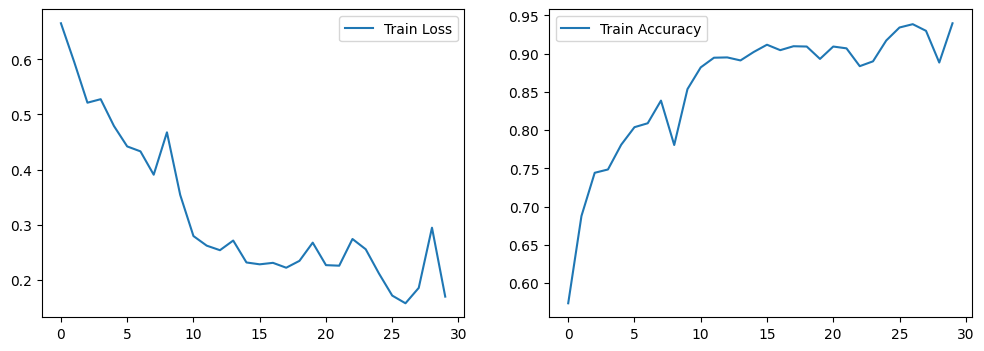

Gini Score (BatchNorm + Noise 0.5): 0.9792

=== BatchNorm + Noise 1 ===
Epoch 1/30 - Loss: 0.6956, Accuracy: 0.5272
Epoch 2/30 - Loss: 0.6643, Accuracy: 0.5777
Epoch 3/30 - Loss: 0.6305, Accuracy: 0.6606
Epoch 4/30 - Loss: 0.6161, Accuracy: 0.6709
Epoch 5/30 - Loss: 0.5656, Accuracy: 0.7226
Epoch 6/30 - Loss: 0.5152, Accuracy: 0.7506
Epoch 7/30 - Loss: 0.4985, Accuracy: 0.7668
Epoch 8/30 - Loss: 0.4651, Accuracy: 0.7833
Epoch 9/30 - Loss: 0.4276, Accuracy: 0.8197
Epoch 10/30 - Loss: 0.3721, Accuracy: 0.8445
Epoch 11/30 - Loss: 0.4595, Accuracy: 0.7944
Epoch 12/30 - Loss: 0.3140, Accuracy: 0.8682
Epoch 13/30 - Loss: 0.3427, Accuracy: 0.8485
Epoch 14/30 - Loss: 0.3217, Accuracy: 0.8615
Epoch 15/30 - Loss: 0.2869, Accuracy: 0.8860
Epoch 16/30 - Loss: 0.3222, Accuracy: 0.8678
Epoch 17/30 - Loss: 0.3074, Accuracy: 0.8773
Epoch 18/30 - Loss: 0.3034, Accuracy: 0.8721
Epoch 19/30 - Loss: 0.2444, Accuracy: 0.9029
Epoch 20/30 - Loss: 0.3010, Accuracy: 0.8820
Epoch 21/30 - Loss: 0.2666, Accuracy:

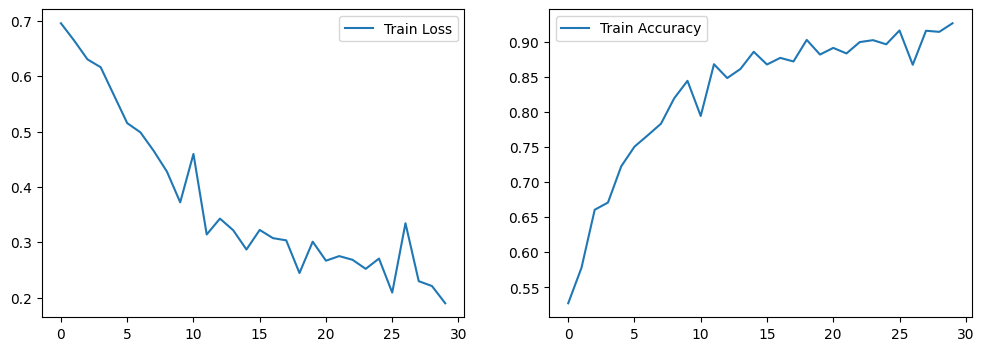

Gini Score (BatchNorm + Noise 1): 0.9621

=== BatchNorm + Noise 2 ===
Epoch 1/30 - Loss: 0.7221, Accuracy: 0.5154
Epoch 2/30 - Loss: 0.6880, Accuracy: 0.5399
Epoch 3/30 - Loss: 0.6665, Accuracy: 0.5872
Epoch 4/30 - Loss: 0.6401, Accuracy: 0.6330
Epoch 5/30 - Loss: 0.5882, Accuracy: 0.6878
Epoch 6/30 - Loss: 0.5756, Accuracy: 0.7032
Epoch 7/30 - Loss: 0.5773, Accuracy: 0.7111
Epoch 8/30 - Loss: 0.5141, Accuracy: 0.7522
Epoch 9/30 - Loss: 0.4907, Accuracy: 0.7747
Epoch 10/30 - Loss: 0.5465, Accuracy: 0.7336
Epoch 11/30 - Loss: 0.5819, Accuracy: 0.7044
Epoch 12/30 - Loss: 0.5161, Accuracy: 0.7526
Epoch 13/30 - Loss: 0.4580, Accuracy: 0.7999
Epoch 14/30 - Loss: 0.4402, Accuracy: 0.8070
Epoch 15/30 - Loss: 0.4358, Accuracy: 0.8122
Epoch 16/30 - Loss: 0.4210, Accuracy: 0.8157
Epoch 17/30 - Loss: 0.4060, Accuracy: 0.8299
Epoch 18/30 - Loss: 0.3733, Accuracy: 0.8421
Epoch 19/30 - Loss: 0.3655, Accuracy: 0.8493
Epoch 20/30 - Loss: 0.3278, Accuracy: 0.8658
Epoch 21/30 - Loss: 0.4036, Accuracy: 0

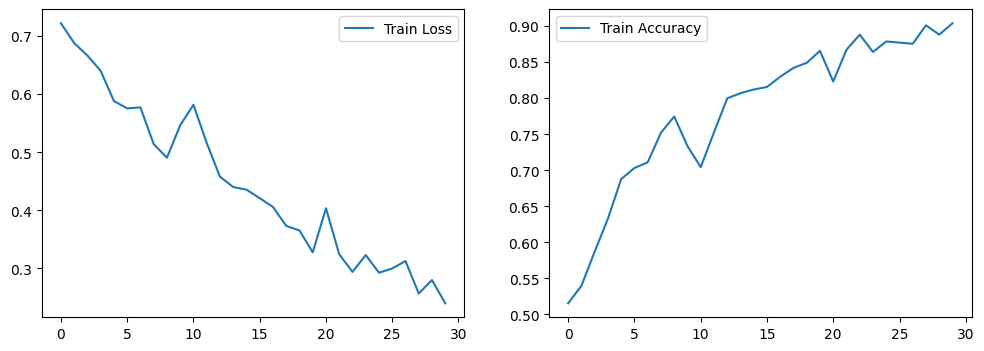

Gini Score (BatchNorm + Noise 2): 0.9567

=== BatchNorm ===
Epoch 1/30 - Loss: 0.6320, Accuracy: 0.6484
Epoch 2/30 - Loss: 0.5390, Accuracy: 0.7526
Epoch 3/30 - Loss: 0.4920, Accuracy: 0.7758
Epoch 4/30 - Loss: 0.4428, Accuracy: 0.8039
Epoch 5/30 - Loss: 0.3573, Accuracy: 0.8591
Epoch 6/30 - Loss: 0.3633, Accuracy: 0.8564
Epoch 7/30 - Loss: 0.3036, Accuracy: 0.8860
Epoch 8/30 - Loss: 0.3262, Accuracy: 0.8694
Epoch 9/30 - Loss: 0.2337, Accuracy: 0.9116
Epoch 10/30 - Loss: 0.1947, Accuracy: 0.9345
Epoch 11/30 - Loss: 0.2175, Accuracy: 0.9203
Epoch 12/30 - Loss: 0.2013, Accuracy: 0.9234
Epoch 13/30 - Loss: 0.1902, Accuracy: 0.9376
Epoch 14/30 - Loss: 0.2663, Accuracy: 0.9238
Epoch 15/30 - Loss: 0.1979, Accuracy: 0.9298
Epoch 16/30 - Loss: 0.1666, Accuracy: 0.9388
Epoch 17/30 - Loss: 0.1749, Accuracy: 0.9317
Epoch 18/30 - Loss: 0.1810, Accuracy: 0.9305
Epoch 19/30 - Loss: 0.1446, Accuracy: 0.9554
Epoch 20/30 - Loss: 0.1504, Accuracy: 0.9507
Epoch 21/30 - Loss: 0.1373, Accuracy: 0.9554
Epoc

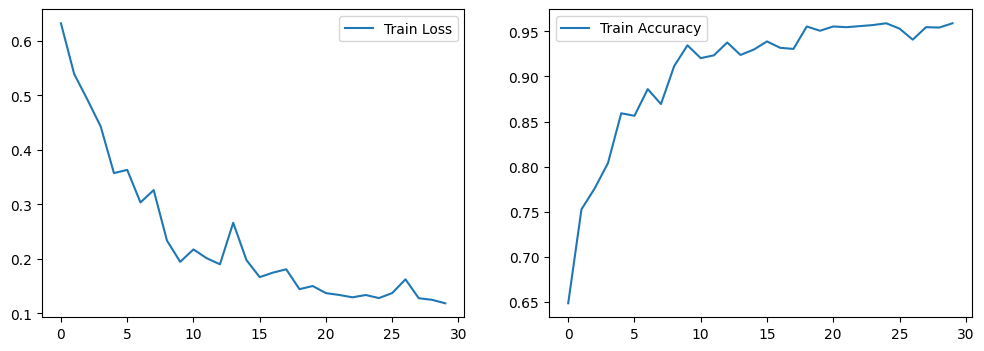

Gini Score (BatchNorm): 0.9738

=== No BatchNorm ===
Epoch 1/30 - Loss: 0.6989, Accuracy: 0.5750
Epoch 2/30 - Loss: 0.6509, Accuracy: 0.6598
Epoch 3/30 - Loss: 0.5662, Accuracy: 0.7088
Epoch 4/30 - Loss: 0.5340, Accuracy: 0.7360
Epoch 5/30 - Loss: 0.5170, Accuracy: 0.7478
Epoch 6/30 - Loss: 0.4865, Accuracy: 0.7605
Epoch 7/30 - Loss: 0.4577, Accuracy: 0.7865
Epoch 8/30 - Loss: 0.4306, Accuracy: 0.8043
Epoch 9/30 - Loss: 0.3987, Accuracy: 0.8346
Epoch 10/30 - Loss: 0.3531, Accuracy: 0.8591
Epoch 11/30 - Loss: 0.4258, Accuracy: 0.8275
Epoch 12/30 - Loss: 0.3171, Accuracy: 0.8792
Epoch 13/30 - Loss: 0.2837, Accuracy: 0.8903
Epoch 14/30 - Loss: 0.2476, Accuracy: 0.9092
Epoch 15/30 - Loss: 0.2341, Accuracy: 0.9084
Epoch 16/30 - Loss: 0.2216, Accuracy: 0.9171
Epoch 17/30 - Loss: 0.1816, Accuracy: 0.9349
Epoch 18/30 - Loss: 0.1774, Accuracy: 0.9361
Epoch 19/30 - Loss: 0.2220, Accuracy: 0.9108
Epoch 20/30 - Loss: 0.2263, Accuracy: 0.9088
Epoch 21/30 - Loss: 0.1650, Accuracy: 0.9420
Epoch 22/30

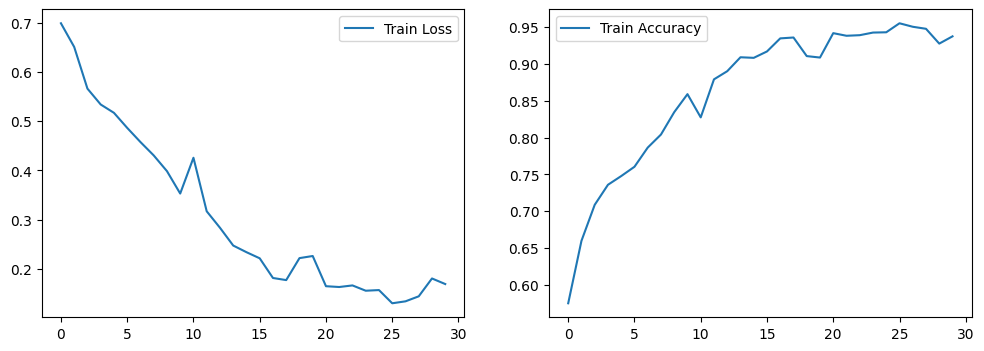

Gini Score (No BatchNorm): 0.9826


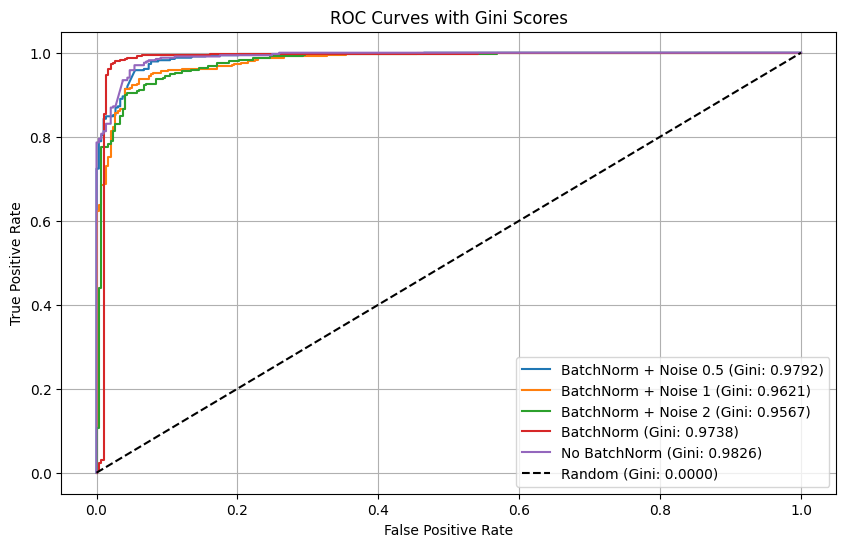

In [5]:
configs = [
    ("BatchNorm + Noise 0.5", True, 0.5),
    ("BatchNorm + Noise 1", True, 1),
    ("BatchNorm + Noise 2", True, 2),
    ("BatchNorm", True, 0.0),
    ("No BatchNorm", False, 0.0),
]

gini_results = []

for config_name, use_bn, noise_scale in configs:
    print(f"\n=== {config_name} ===")
    model = NeuralNetwork(input_size=X_train.shape[1], hidden_layer_1=16, hidden_layer_2=8, use_batch_norm=use_bn, noise_scale=noise_scale)
    model = train_model(model, train_loader, epochs=30, learning_rate=0.01)
    
    # Evaluation
    model.eval()
    y_true = []
    y_probs = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            y_true.extend(y_batch.numpy().flatten())
            y_probs.extend(outputs.numpy().flatten())

    gini_score, fpr, tpr = compute_gini(y_true, y_probs)
    gini_results.append((config_name, gini_score, fpr, tpr))

    print(f"Gini Score ({config_name}): {gini_score:.4f}")

# ROC and Gini score
plt.figure(figsize=(10, 6))
for config_name, gini_score, fpr, tpr in gini_results:
    plt.plot(fpr, tpr, label=f"{config_name} (Gini: {gini_score:.4f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random (Gini: 0.0000)")
plt.title("ROC Curves with Gini Scores")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()


=== BatchNorm + Noise 0.5 ===
Epoch 1/30 - Loss: 0.6694, Accuracy: 0.5833
Epoch 2/30 - Loss: 0.6084, Accuracy: 0.6823
Epoch 3/30 - Loss: 0.5402, Accuracy: 0.7360
Epoch 4/30 - Loss: 0.5085, Accuracy: 0.7605
Epoch 5/30 - Loss: 0.4714, Accuracy: 0.7857
Epoch 6/30 - Loss: 0.4245, Accuracy: 0.8137
Epoch 7/30 - Loss: 0.4687, Accuracy: 0.7794
Epoch 8/30 - Loss: 0.3884, Accuracy: 0.8370
Epoch 9/30 - Loss: 0.5428, Accuracy: 0.7340
Epoch 10/30 - Loss: 0.4517, Accuracy: 0.8015
Epoch 11/30 - Loss: 0.3554, Accuracy: 0.8607
Epoch 12/30 - Loss: 0.3678, Accuracy: 0.8386
Epoch 13/30 - Loss: 0.3917, Accuracy: 0.8489
Epoch 14/30 - Loss: 0.3379, Accuracy: 0.8587
Epoch 15/30 - Loss: 0.2829, Accuracy: 0.8804
Epoch 16/30 - Loss: 0.2536, Accuracy: 0.8970
Epoch 17/30 - Loss: 0.3397, Accuracy: 0.8552
Epoch 18/30 - Loss: 0.2786, Accuracy: 0.8781
Epoch 19/30 - Loss: 0.2968, Accuracy: 0.8654
Epoch 20/30 - Loss: 0.2355, Accuracy: 0.9037
Epoch 21/30 - Loss: 0.3438, Accuracy: 0.8812
Epoch 22/30 - Loss: 0.2491, Accur

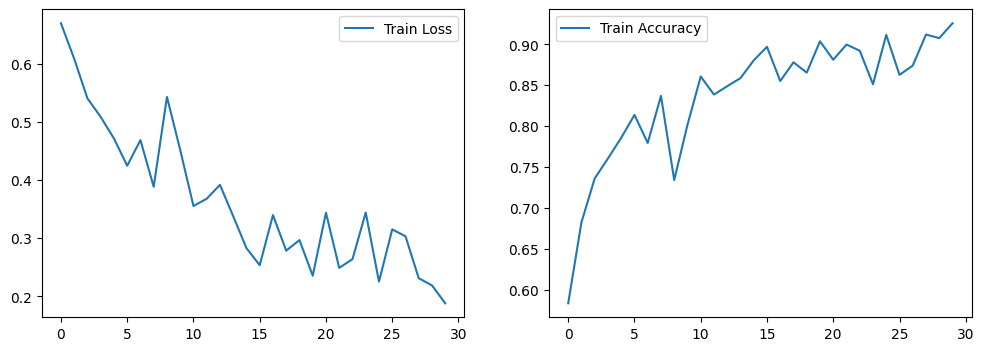

Epoch 1/30 - Loss: 0.6673, Accuracy: 0.5746
Epoch 2/30 - Loss: 0.5922, Accuracy: 0.6882
Epoch 3/30 - Loss: 0.5620, Accuracy: 0.7135
Epoch 4/30 - Loss: 0.5082, Accuracy: 0.7612
Epoch 5/30 - Loss: 0.5308, Accuracy: 0.7443
Epoch 6/30 - Loss: 0.4460, Accuracy: 0.8011
Epoch 7/30 - Loss: 0.4776, Accuracy: 0.7786
Epoch 8/30 - Loss: 0.4286, Accuracy: 0.8129
Epoch 9/30 - Loss: 0.4033, Accuracy: 0.8260
Epoch 10/30 - Loss: 0.4087, Accuracy: 0.8248
Epoch 11/30 - Loss: 0.2964, Accuracy: 0.8741
Epoch 12/30 - Loss: 0.2847, Accuracy: 0.8867
Epoch 13/30 - Loss: 0.2523, Accuracy: 0.8982
Epoch 14/30 - Loss: 0.2693, Accuracy: 0.8871
Epoch 15/30 - Loss: 0.2789, Accuracy: 0.8820
Epoch 16/30 - Loss: 0.2428, Accuracy: 0.9065
Epoch 17/30 - Loss: 0.1964, Accuracy: 0.9227
Epoch 18/30 - Loss: 0.1662, Accuracy: 0.9404
Epoch 19/30 - Loss: 0.1834, Accuracy: 0.9286
Epoch 20/30 - Loss: 0.1655, Accuracy: 0.9376
Epoch 21/30 - Loss: 0.2025, Accuracy: 0.9238
Epoch 22/30 - Loss: 0.2281, Accuracy: 0.9120
Epoch 23/30 - Loss:

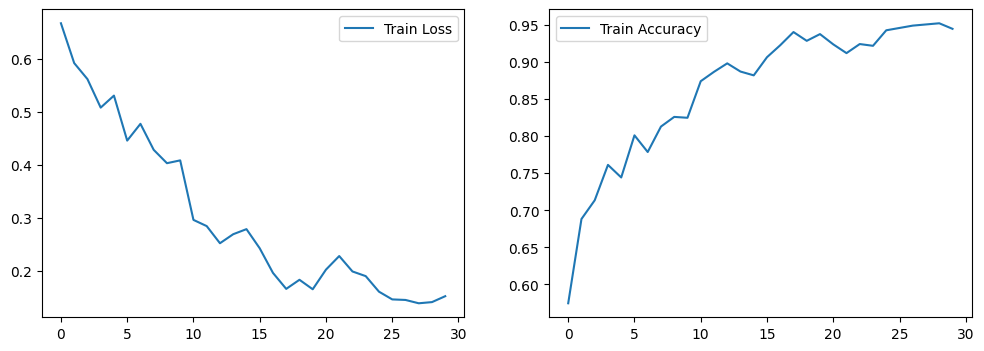

Epoch 1/30 - Loss: 0.6587, Accuracy: 0.5979
Epoch 2/30 - Loss: 0.5956, Accuracy: 0.6878
Epoch 3/30 - Loss: 0.5692, Accuracy: 0.7210
Epoch 4/30 - Loss: 0.5042, Accuracy: 0.7553
Epoch 5/30 - Loss: 0.5067, Accuracy: 0.7537
Epoch 6/30 - Loss: 0.4417, Accuracy: 0.8058
Epoch 7/30 - Loss: 0.4606, Accuracy: 0.7901
Epoch 8/30 - Loss: 0.4078, Accuracy: 0.8272
Epoch 9/30 - Loss: 0.3516, Accuracy: 0.8473
Epoch 10/30 - Loss: 0.3244, Accuracy: 0.8698
Epoch 11/30 - Loss: 0.3007, Accuracy: 0.8654
Epoch 12/30 - Loss: 0.3842, Accuracy: 0.8402
Epoch 13/30 - Loss: 0.2845, Accuracy: 0.8867
Epoch 14/30 - Loss: 0.4038, Accuracy: 0.8252
Epoch 15/30 - Loss: 0.3335, Accuracy: 0.8607
Epoch 16/30 - Loss: 0.2954, Accuracy: 0.8852
Epoch 17/30 - Loss: 0.2719, Accuracy: 0.8927
Epoch 18/30 - Loss: 0.2998, Accuracy: 0.8753
Epoch 19/30 - Loss: 0.2925, Accuracy: 0.8883
Epoch 20/30 - Loss: 0.2847, Accuracy: 0.8938
Epoch 21/30 - Loss: 0.2699, Accuracy: 0.8950
Epoch 22/30 - Loss: 0.2662, Accuracy: 0.8923
Epoch 23/30 - Loss:

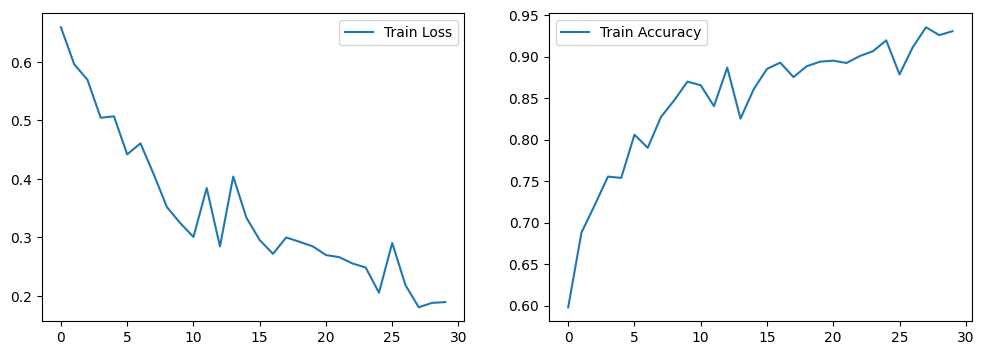

Epoch 1/30 - Loss: 0.6865, Accuracy: 0.5485
Epoch 2/30 - Loss: 0.6030, Accuracy: 0.6906
Epoch 3/30 - Loss: 0.5411, Accuracy: 0.7320
Epoch 4/30 - Loss: 0.4924, Accuracy: 0.7676
Epoch 5/30 - Loss: 0.4649, Accuracy: 0.7877
Epoch 6/30 - Loss: 0.4200, Accuracy: 0.8260
Epoch 7/30 - Loss: 0.4799, Accuracy: 0.7747
Epoch 8/30 - Loss: 0.4030, Accuracy: 0.8264
Epoch 9/30 - Loss: 0.3880, Accuracy: 0.8327
Epoch 10/30 - Loss: 0.2868, Accuracy: 0.8860
Epoch 11/30 - Loss: 0.3169, Accuracy: 0.8623
Epoch 12/30 - Loss: 0.2941, Accuracy: 0.8828
Epoch 13/30 - Loss: 0.2735, Accuracy: 0.8923
Epoch 14/30 - Loss: 0.2476, Accuracy: 0.8958
Epoch 15/30 - Loss: 0.2689, Accuracy: 0.8741
Epoch 16/30 - Loss: 0.2801, Accuracy: 0.8844
Epoch 17/30 - Loss: 0.2030, Accuracy: 0.9183
Epoch 18/30 - Loss: 0.2286, Accuracy: 0.9021
Epoch 19/30 - Loss: 0.2316, Accuracy: 0.9088
Epoch 20/30 - Loss: 0.1921, Accuracy: 0.9254
Epoch 21/30 - Loss: 0.1741, Accuracy: 0.9345
Epoch 22/30 - Loss: 0.1772, Accuracy: 0.9301
Epoch 23/30 - Loss:

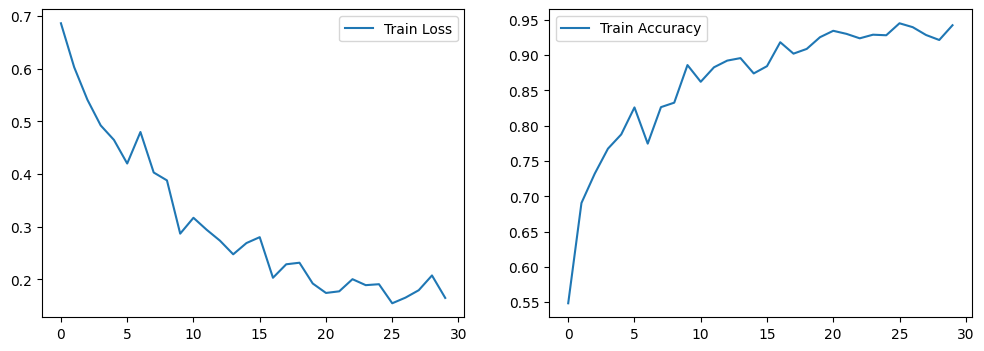

Epoch 1/30 - Loss: 0.6811, Accuracy: 0.5572
Epoch 2/30 - Loss: 0.5965, Accuracy: 0.6961
Epoch 3/30 - Loss: 0.5576, Accuracy: 0.7222
Epoch 4/30 - Loss: 0.4946, Accuracy: 0.7758
Epoch 5/30 - Loss: 0.5290, Accuracy: 0.7423
Epoch 6/30 - Loss: 0.4720, Accuracy: 0.7873
Epoch 7/30 - Loss: 0.4681, Accuracy: 0.7766
Epoch 8/30 - Loss: 0.3941, Accuracy: 0.8319
Epoch 9/30 - Loss: 0.4092, Accuracy: 0.8268
Epoch 10/30 - Loss: 0.3233, Accuracy: 0.8694
Epoch 11/30 - Loss: 0.4218, Accuracy: 0.8090
Epoch 12/30 - Loss: 0.3636, Accuracy: 0.8429
Epoch 13/30 - Loss: 0.3692, Accuracy: 0.8473
Epoch 14/30 - Loss: 0.2915, Accuracy: 0.8757
Epoch 15/30 - Loss: 0.2989, Accuracy: 0.8686
Epoch 16/30 - Loss: 0.2602, Accuracy: 0.8891
Epoch 17/30 - Loss: 0.2778, Accuracy: 0.8832
Epoch 18/30 - Loss: 0.2273, Accuracy: 0.9057
Epoch 19/30 - Loss: 0.2390, Accuracy: 0.8927
Epoch 20/30 - Loss: 0.3501, Accuracy: 0.8587
Epoch 21/30 - Loss: 0.3465, Accuracy: 0.8646
Epoch 22/30 - Loss: 0.2682, Accuracy: 0.8907
Epoch 23/30 - Loss:

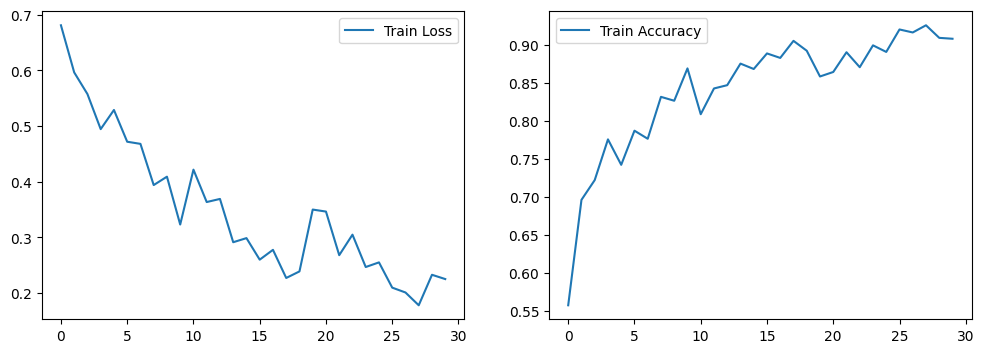

Epoch 1/30 - Loss: 0.6682, Accuracy: 0.5884
Epoch 2/30 - Loss: 0.6172, Accuracy: 0.6693
Epoch 3/30 - Loss: 0.5434, Accuracy: 0.7332
Epoch 4/30 - Loss: 0.5034, Accuracy: 0.7636
Epoch 5/30 - Loss: 0.4824, Accuracy: 0.7766
Epoch 6/30 - Loss: 0.4493, Accuracy: 0.7995
Epoch 7/30 - Loss: 0.4283, Accuracy: 0.8058
Epoch 8/30 - Loss: 0.4751, Accuracy: 0.7841
Epoch 9/30 - Loss: 0.3696, Accuracy: 0.8457
Epoch 10/30 - Loss: 0.3456, Accuracy: 0.8587
Epoch 11/30 - Loss: 0.3339, Accuracy: 0.8591
Epoch 12/30 - Loss: 0.4354, Accuracy: 0.8414
Epoch 13/30 - Loss: 0.2994, Accuracy: 0.8773
Epoch 14/30 - Loss: 0.2658, Accuracy: 0.8899
Epoch 15/30 - Loss: 0.3203, Accuracy: 0.8591
Epoch 16/30 - Loss: 0.2687, Accuracy: 0.8974
Epoch 17/30 - Loss: 0.2504, Accuracy: 0.8990
Epoch 18/30 - Loss: 0.2454, Accuracy: 0.9057
Epoch 19/30 - Loss: 0.2704, Accuracy: 0.8903
Epoch 20/30 - Loss: 0.2711, Accuracy: 0.8871
Epoch 21/30 - Loss: 0.2803, Accuracy: 0.8950
Epoch 22/30 - Loss: 0.2644, Accuracy: 0.8927
Epoch 23/30 - Loss:

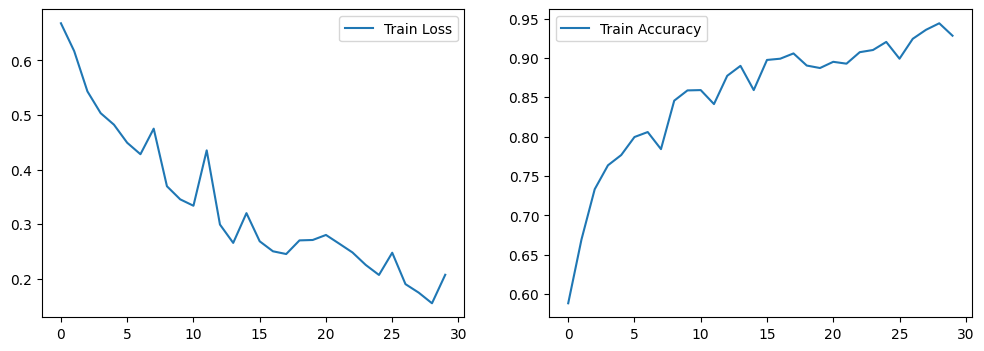

Epoch 1/30 - Loss: 0.6713, Accuracy: 0.5766
Epoch 2/30 - Loss: 0.6385, Accuracy: 0.6507
Epoch 3/30 - Loss: 0.5778, Accuracy: 0.7107
Epoch 4/30 - Loss: 0.5293, Accuracy: 0.7391
Epoch 5/30 - Loss: 0.4884, Accuracy: 0.7782
Epoch 6/30 - Loss: 0.4695, Accuracy: 0.7885
Epoch 7/30 - Loss: 0.4007, Accuracy: 0.8311
Epoch 8/30 - Loss: 0.3671, Accuracy: 0.8508
Epoch 9/30 - Loss: 0.4402, Accuracy: 0.8090
Epoch 10/30 - Loss: 0.2759, Accuracy: 0.8879
Epoch 11/30 - Loss: 0.2692, Accuracy: 0.8848
Epoch 12/30 - Loss: 0.1942, Accuracy: 0.9266
Epoch 13/30 - Loss: 0.2499, Accuracy: 0.8899
Epoch 14/30 - Loss: 0.3115, Accuracy: 0.8698
Epoch 15/30 - Loss: 0.2598, Accuracy: 0.8934
Epoch 16/30 - Loss: 0.2096, Accuracy: 0.9246
Epoch 17/30 - Loss: 0.1775, Accuracy: 0.9357
Epoch 18/30 - Loss: 0.1623, Accuracy: 0.9376
Epoch 19/30 - Loss: 0.1724, Accuracy: 0.9357
Epoch 20/30 - Loss: 0.1622, Accuracy: 0.9400
Epoch 21/30 - Loss: 0.1545, Accuracy: 0.9440
Epoch 22/30 - Loss: 0.1553, Accuracy: 0.9440
Epoch 23/30 - Loss:

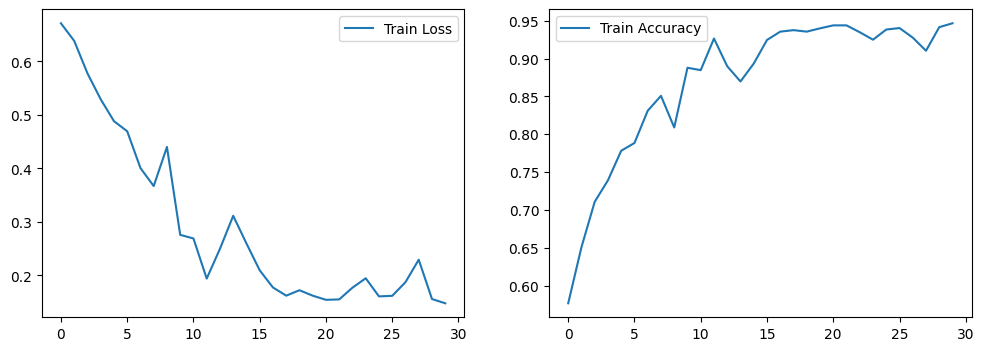

Epoch 1/30 - Loss: 0.6740, Accuracy: 0.5568
Epoch 2/30 - Loss: 0.6226, Accuracy: 0.6646
Epoch 3/30 - Loss: 0.5470, Accuracy: 0.7226
Epoch 4/30 - Loss: 0.5017, Accuracy: 0.7695
Epoch 5/30 - Loss: 0.5631, Accuracy: 0.7139
Epoch 6/30 - Loss: 0.4610, Accuracy: 0.7932
Epoch 7/30 - Loss: 0.4419, Accuracy: 0.8058
Epoch 8/30 - Loss: 0.4086, Accuracy: 0.8204
Epoch 9/30 - Loss: 0.3999, Accuracy: 0.8236
Epoch 10/30 - Loss: 0.3074, Accuracy: 0.8686
Epoch 11/30 - Loss: 0.2788, Accuracy: 0.8852
Epoch 12/30 - Loss: 0.3052, Accuracy: 0.8761
Epoch 13/30 - Loss: 0.3363, Accuracy: 0.8599
Epoch 14/30 - Loss: 0.2483, Accuracy: 0.8970
Epoch 15/30 - Loss: 0.2330, Accuracy: 0.9053
Epoch 16/30 - Loss: 0.3213, Accuracy: 0.8694
Epoch 17/30 - Loss: 0.2737, Accuracy: 0.8970
Epoch 18/30 - Loss: 0.2364, Accuracy: 0.9017
Epoch 19/30 - Loss: 0.2525, Accuracy: 0.8934
Epoch 20/30 - Loss: 0.2337, Accuracy: 0.9013
Epoch 21/30 - Loss: 0.2304, Accuracy: 0.9025
Epoch 22/30 - Loss: 0.1998, Accuracy: 0.9183
Epoch 23/30 - Loss:

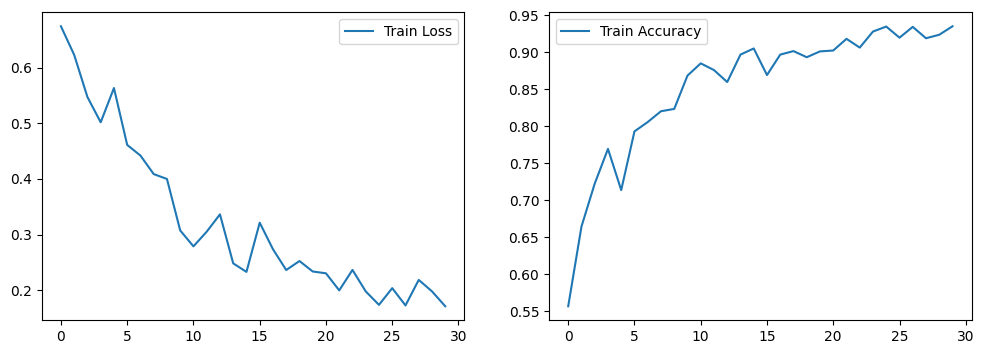

Epoch 1/30 - Loss: 0.6763, Accuracy: 0.5675
Epoch 2/30 - Loss: 0.6116, Accuracy: 0.6772
Epoch 3/30 - Loss: 0.5319, Accuracy: 0.7395
Epoch 4/30 - Loss: 0.4963, Accuracy: 0.7723
Epoch 5/30 - Loss: 0.4539, Accuracy: 0.8039
Epoch 6/30 - Loss: 0.4028, Accuracy: 0.8299
Epoch 7/30 - Loss: 0.3590, Accuracy: 0.8575
Epoch 8/30 - Loss: 0.3481, Accuracy: 0.8583
Epoch 9/30 - Loss: 0.4323, Accuracy: 0.8031
Epoch 10/30 - Loss: 0.3434, Accuracy: 0.8654
Epoch 11/30 - Loss: 0.2729, Accuracy: 0.8891
Epoch 12/30 - Loss: 0.3179, Accuracy: 0.8745
Epoch 13/30 - Loss: 0.3052, Accuracy: 0.8619
Epoch 14/30 - Loss: 0.2503, Accuracy: 0.8907
Epoch 15/30 - Loss: 0.3639, Accuracy: 0.8275
Epoch 16/30 - Loss: 0.4094, Accuracy: 0.8090
Epoch 17/30 - Loss: 0.2863, Accuracy: 0.8717
Epoch 18/30 - Loss: 0.2752, Accuracy: 0.8852
Epoch 19/30 - Loss: 0.2910, Accuracy: 0.8796
Epoch 20/30 - Loss: 0.2142, Accuracy: 0.9108
Epoch 21/30 - Loss: 0.2126, Accuracy: 0.9152
Epoch 22/30 - Loss: 0.2074, Accuracy: 0.9227
Epoch 23/30 - Loss:

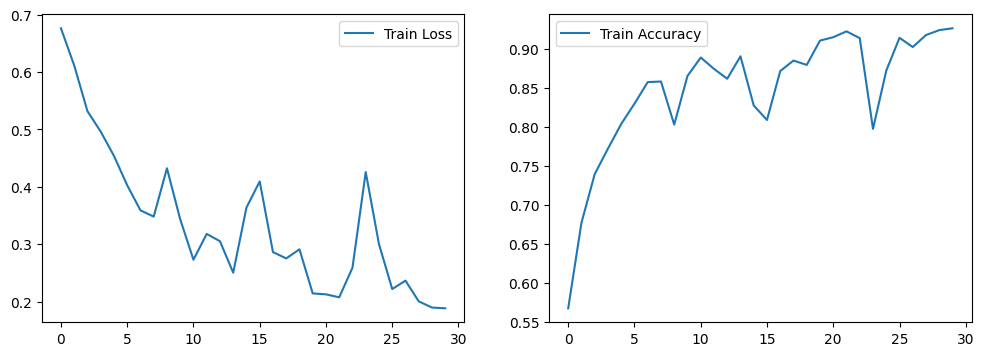

Epoch 1/30 - Loss: 0.6896, Accuracy: 0.5387
Epoch 2/30 - Loss: 0.6303, Accuracy: 0.6448
Epoch 3/30 - Loss: 0.5522, Accuracy: 0.7238
Epoch 4/30 - Loss: 0.4926, Accuracy: 0.7715
Epoch 5/30 - Loss: 0.4453, Accuracy: 0.7999
Epoch 6/30 - Loss: 0.4432, Accuracy: 0.8058
Epoch 7/30 - Loss: 0.4186, Accuracy: 0.8236
Epoch 8/30 - Loss: 0.4057, Accuracy: 0.8272
Epoch 9/30 - Loss: 0.3625, Accuracy: 0.8504
Epoch 10/30 - Loss: 0.3422, Accuracy: 0.8654
Epoch 11/30 - Loss: 0.3065, Accuracy: 0.8729
Epoch 12/30 - Loss: 0.4082, Accuracy: 0.8125
Epoch 13/30 - Loss: 0.3433, Accuracy: 0.8631
Epoch 14/30 - Loss: 0.3141, Accuracy: 0.8788
Epoch 15/30 - Loss: 0.3016, Accuracy: 0.8812
Epoch 16/30 - Loss: 0.2523, Accuracy: 0.8907
Epoch 17/30 - Loss: 0.2749, Accuracy: 0.8895
Epoch 18/30 - Loss: 0.2527, Accuracy: 0.8934
Epoch 19/30 - Loss: 0.2587, Accuracy: 0.8915
Epoch 20/30 - Loss: 0.2512, Accuracy: 0.9065
Epoch 21/30 - Loss: 0.2562, Accuracy: 0.8974
Epoch 22/30 - Loss: 0.2396, Accuracy: 0.9084
Epoch 23/30 - Loss:

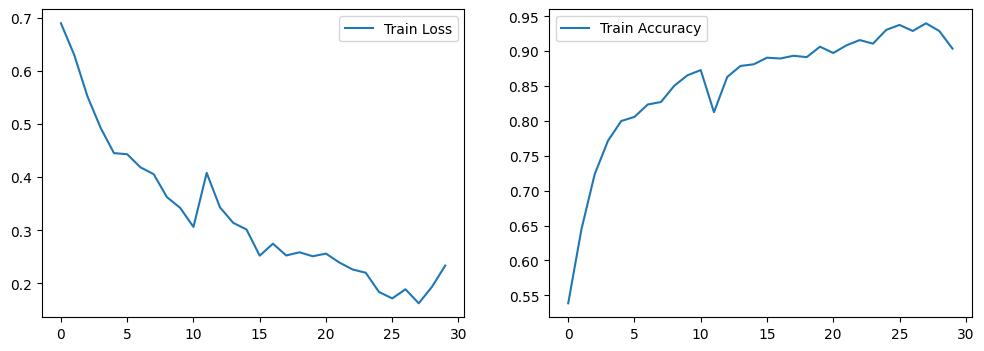


=== BatchNorm + Noise 1 ===
Epoch 1/30 - Loss: 0.6929, Accuracy: 0.5462
Epoch 2/30 - Loss: 0.6356, Accuracy: 0.6444
Epoch 3/30 - Loss: 0.6264, Accuracy: 0.6575
Epoch 4/30 - Loss: 0.5643, Accuracy: 0.7174
Epoch 5/30 - Loss: 0.5325, Accuracy: 0.7313
Epoch 6/30 - Loss: 0.4929, Accuracy: 0.7727
Epoch 7/30 - Loss: 0.4618, Accuracy: 0.7940
Epoch 8/30 - Loss: 0.4403, Accuracy: 0.8098
Epoch 9/30 - Loss: 0.4989, Accuracy: 0.7747
Epoch 10/30 - Loss: 0.3890, Accuracy: 0.8457
Epoch 11/30 - Loss: 0.3566, Accuracy: 0.8564
Epoch 12/30 - Loss: 0.4565, Accuracy: 0.8007
Epoch 13/30 - Loss: 0.3906, Accuracy: 0.8358
Epoch 14/30 - Loss: 0.3466, Accuracy: 0.8619
Epoch 15/30 - Loss: 0.3256, Accuracy: 0.8721
Epoch 16/30 - Loss: 0.2912, Accuracy: 0.8867
Epoch 17/30 - Loss: 0.4241, Accuracy: 0.8090
Epoch 18/30 - Loss: 0.5808, Accuracy: 0.7001
Epoch 19/30 - Loss: 0.4809, Accuracy: 0.7751
Epoch 20/30 - Loss: 0.3793, Accuracy: 0.8279
Epoch 21/30 - Loss: 0.3327, Accuracy: 0.8512
Epoch 22/30 - Loss: 0.2715, Accurac

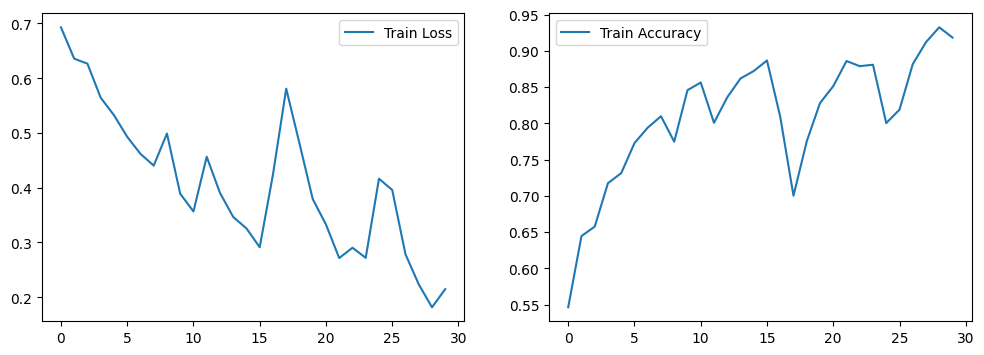

Epoch 1/30 - Loss: 0.7045, Accuracy: 0.5276
Epoch 2/30 - Loss: 0.6573, Accuracy: 0.6026
Epoch 3/30 - Loss: 0.6181, Accuracy: 0.6594
Epoch 4/30 - Loss: 0.5979, Accuracy: 0.6803
Epoch 5/30 - Loss: 0.5420, Accuracy: 0.7384
Epoch 6/30 - Loss: 0.5227, Accuracy: 0.7506
Epoch 7/30 - Loss: 0.4883, Accuracy: 0.7810
Epoch 8/30 - Loss: 0.4411, Accuracy: 0.8074
Epoch 9/30 - Loss: 0.4628, Accuracy: 0.7893
Epoch 10/30 - Loss: 0.4105, Accuracy: 0.8311
Epoch 11/30 - Loss: 0.4474, Accuracy: 0.7964
Epoch 12/30 - Loss: 0.4108, Accuracy: 0.8291
Epoch 13/30 - Loss: 0.3708, Accuracy: 0.8548
Epoch 14/30 - Loss: 0.3745, Accuracy: 0.8532
Epoch 15/30 - Loss: 0.3305, Accuracy: 0.8710
Epoch 16/30 - Loss: 0.3059, Accuracy: 0.8808
Epoch 17/30 - Loss: 0.3097, Accuracy: 0.8867
Epoch 18/30 - Loss: 0.2689, Accuracy: 0.8899
Epoch 19/30 - Loss: 0.3072, Accuracy: 0.8769
Epoch 20/30 - Loss: 0.3099, Accuracy: 0.8761
Epoch 21/30 - Loss: 0.3001, Accuracy: 0.8800
Epoch 22/30 - Loss: 0.2436, Accuracy: 0.8974
Epoch 23/30 - Loss:

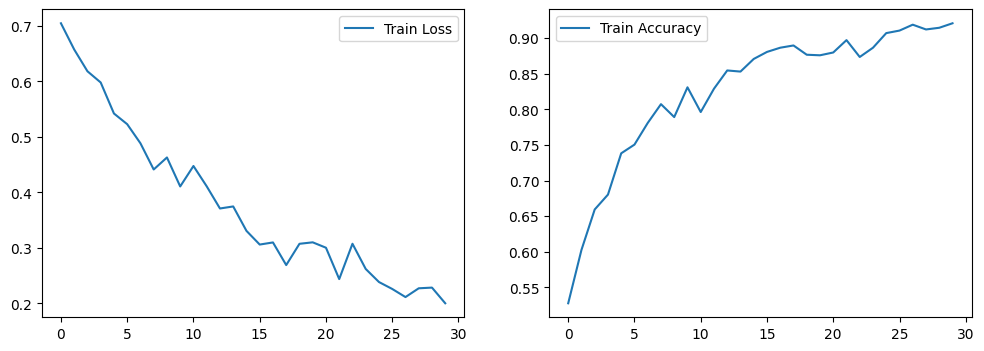

Epoch 1/30 - Loss: 0.6940, Accuracy: 0.5304
Epoch 2/30 - Loss: 0.6554, Accuracy: 0.6196
Epoch 3/30 - Loss: 0.6091, Accuracy: 0.6752
Epoch 4/30 - Loss: 0.6143, Accuracy: 0.6736
Epoch 5/30 - Loss: 0.5471, Accuracy: 0.7285
Epoch 6/30 - Loss: 0.5537, Accuracy: 0.7222
Epoch 7/30 - Loss: 0.4840, Accuracy: 0.7814
Epoch 8/30 - Loss: 0.4622, Accuracy: 0.7952
Epoch 9/30 - Loss: 0.4574, Accuracy: 0.7956
Epoch 10/30 - Loss: 0.4477, Accuracy: 0.8066
Epoch 11/30 - Loss: 0.3743, Accuracy: 0.8469
Epoch 12/30 - Loss: 0.3252, Accuracy: 0.8646
Epoch 13/30 - Loss: 0.3404, Accuracy: 0.8548
Epoch 14/30 - Loss: 0.3248, Accuracy: 0.8587
Epoch 15/30 - Loss: 0.3394, Accuracy: 0.8524
Epoch 16/30 - Loss: 0.2287, Accuracy: 0.9155
Epoch 17/30 - Loss: 0.2492, Accuracy: 0.8974
Epoch 18/30 - Loss: 0.2905, Accuracy: 0.8804
Epoch 19/30 - Loss: 0.2338, Accuracy: 0.9108
Epoch 20/30 - Loss: 0.1928, Accuracy: 0.9215
Epoch 21/30 - Loss: 0.1632, Accuracy: 0.9420
Epoch 22/30 - Loss: 0.1544, Accuracy: 0.9376
Epoch 23/30 - Loss:

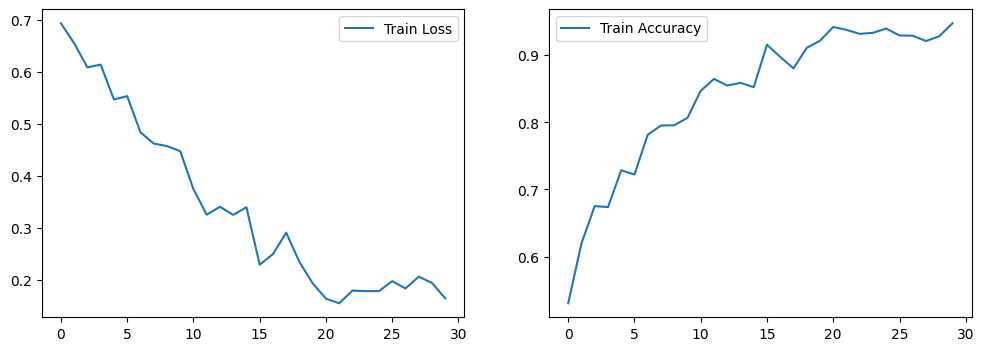

Epoch 1/30 - Loss: 0.6916, Accuracy: 0.5316
Epoch 2/30 - Loss: 0.6539, Accuracy: 0.6022
Epoch 3/30 - Loss: 0.5853, Accuracy: 0.6993
Epoch 4/30 - Loss: 0.5376, Accuracy: 0.7463
Epoch 5/30 - Loss: 0.5569, Accuracy: 0.7206
Epoch 6/30 - Loss: 0.4768, Accuracy: 0.7853
Epoch 7/30 - Loss: 0.4441, Accuracy: 0.8110
Epoch 8/30 - Loss: 0.4408, Accuracy: 0.8149
Epoch 9/30 - Loss: 0.4765, Accuracy: 0.7948
Epoch 10/30 - Loss: 0.6457, Accuracy: 0.6243
Epoch 11/30 - Loss: 0.5111, Accuracy: 0.7581
Epoch 12/30 - Loss: 0.4417, Accuracy: 0.8023
Epoch 13/30 - Loss: 0.4556, Accuracy: 0.7987
Epoch 14/30 - Loss: 0.4140, Accuracy: 0.8240
Epoch 15/30 - Loss: 0.3596, Accuracy: 0.8579
Epoch 16/30 - Loss: 0.3110, Accuracy: 0.8860
Epoch 17/30 - Loss: 0.2858, Accuracy: 0.8919
Epoch 18/30 - Loss: 0.3003, Accuracy: 0.8804
Epoch 19/30 - Loss: 0.4343, Accuracy: 0.7979
Epoch 20/30 - Loss: 0.3563, Accuracy: 0.8528
Epoch 21/30 - Loss: 0.3148, Accuracy: 0.8749
Epoch 22/30 - Loss: 0.2763, Accuracy: 0.8796
Epoch 23/30 - Loss:

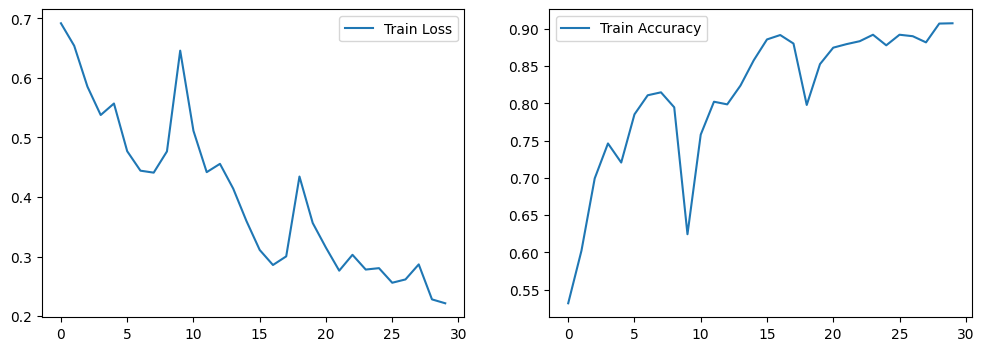

Epoch 1/30 - Loss: 0.6932, Accuracy: 0.5462
Epoch 2/30 - Loss: 0.6511, Accuracy: 0.6196
Epoch 3/30 - Loss: 0.6261, Accuracy: 0.6523
Epoch 4/30 - Loss: 0.5607, Accuracy: 0.7340
Epoch 5/30 - Loss: 0.5869, Accuracy: 0.6922
Epoch 6/30 - Loss: 0.5688, Accuracy: 0.7186
Epoch 7/30 - Loss: 0.5032, Accuracy: 0.7830
Epoch 8/30 - Loss: 0.4383, Accuracy: 0.8106
Epoch 9/30 - Loss: 0.4180, Accuracy: 0.8212
Epoch 10/30 - Loss: 0.4390, Accuracy: 0.8133
Epoch 11/30 - Loss: 0.4943, Accuracy: 0.7616
Epoch 12/30 - Loss: 0.3806, Accuracy: 0.8449
Epoch 13/30 - Loss: 0.4332, Accuracy: 0.7999
Epoch 14/30 - Loss: 0.3669, Accuracy: 0.8540
Epoch 15/30 - Loss: 0.3755, Accuracy: 0.8524
Epoch 16/30 - Loss: 0.3178, Accuracy: 0.8706
Epoch 17/30 - Loss: 0.4949, Accuracy: 0.7601
Epoch 18/30 - Loss: 0.4046, Accuracy: 0.8283
Epoch 19/30 - Loss: 0.3575, Accuracy: 0.8548
Epoch 20/30 - Loss: 0.2862, Accuracy: 0.8848
Epoch 21/30 - Loss: 0.2945, Accuracy: 0.8824
Epoch 22/30 - Loss: 0.2827, Accuracy: 0.8871
Epoch 23/30 - Loss:

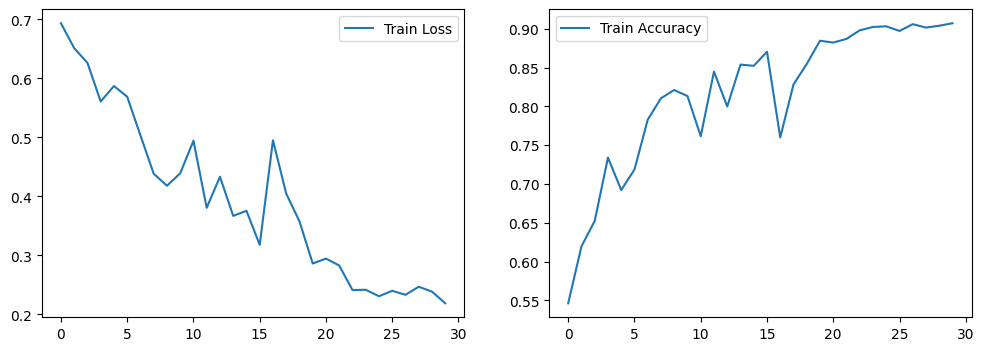

Epoch 1/30 - Loss: 0.6976, Accuracy: 0.5257
Epoch 2/30 - Loss: 0.6619, Accuracy: 0.6042
Epoch 3/30 - Loss: 0.6253, Accuracy: 0.6586
Epoch 4/30 - Loss: 0.5639, Accuracy: 0.7190
Epoch 5/30 - Loss: 0.5321, Accuracy: 0.7407
Epoch 6/30 - Loss: 0.5039, Accuracy: 0.7668
Epoch 7/30 - Loss: 0.4946, Accuracy: 0.7719
Epoch 8/30 - Loss: 0.4473, Accuracy: 0.7952
Epoch 9/30 - Loss: 0.4132, Accuracy: 0.8287
Epoch 10/30 - Loss: 0.3776, Accuracy: 0.8481
Epoch 11/30 - Loss: 0.3455, Accuracy: 0.8686
Epoch 12/30 - Loss: 0.2890, Accuracy: 0.8769
Epoch 13/30 - Loss: 0.6480, Accuracy: 0.6610
Epoch 14/30 - Loss: 0.4584, Accuracy: 0.7861
Epoch 15/30 - Loss: 0.4435, Accuracy: 0.7928
Epoch 16/30 - Loss: 0.3497, Accuracy: 0.8536
Epoch 17/30 - Loss: 0.2672, Accuracy: 0.8871
Epoch 18/30 - Loss: 0.2450, Accuracy: 0.9013
Epoch 19/30 - Loss: 0.2946, Accuracy: 0.8773
Epoch 20/30 - Loss: 0.2525, Accuracy: 0.9002
Epoch 21/30 - Loss: 0.2194, Accuracy: 0.9120
Epoch 22/30 - Loss: 0.2360, Accuracy: 0.9081
Epoch 23/30 - Loss:

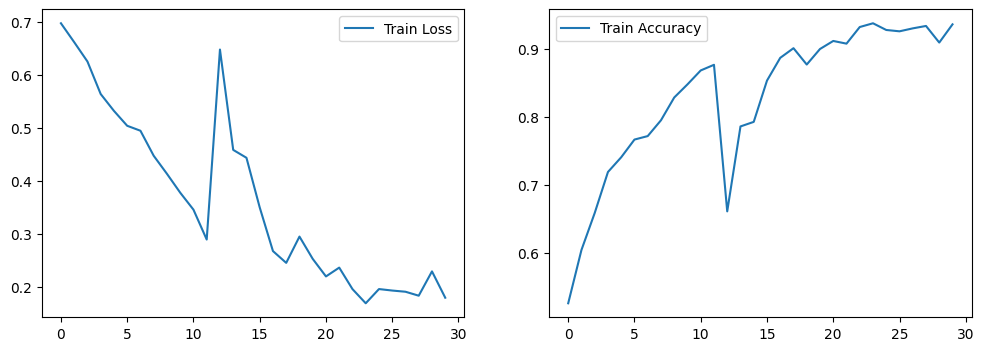

Epoch 1/30 - Loss: 0.6906, Accuracy: 0.5458
Epoch 2/30 - Loss: 0.6706, Accuracy: 0.5714
Epoch 3/30 - Loss: 0.6615, Accuracy: 0.6081
Epoch 4/30 - Loss: 0.6295, Accuracy: 0.6681
Epoch 5/30 - Loss: 0.6014, Accuracy: 0.6890
Epoch 6/30 - Loss: 0.5608, Accuracy: 0.7170
Epoch 7/30 - Loss: 0.5303, Accuracy: 0.7399
Epoch 8/30 - Loss: 0.5135, Accuracy: 0.7553
Epoch 9/30 - Loss: 0.4878, Accuracy: 0.7735
Epoch 10/30 - Loss: 0.4444, Accuracy: 0.8110
Epoch 11/30 - Loss: 0.4965, Accuracy: 0.7719
Epoch 12/30 - Loss: 0.4092, Accuracy: 0.8264
Epoch 13/30 - Loss: 0.3290, Accuracy: 0.8639
Epoch 14/30 - Loss: 0.4051, Accuracy: 0.8264
Epoch 15/30 - Loss: 0.3325, Accuracy: 0.8536
Epoch 16/30 - Loss: 0.3209, Accuracy: 0.8682
Epoch 17/30 - Loss: 0.3197, Accuracy: 0.8674
Epoch 18/30 - Loss: 0.2701, Accuracy: 0.8887
Epoch 19/30 - Loss: 0.3246, Accuracy: 0.8611
Epoch 20/30 - Loss: 0.3652, Accuracy: 0.8382
Epoch 21/30 - Loss: 0.3096, Accuracy: 0.8725
Epoch 22/30 - Loss: 0.2461, Accuracy: 0.8950
Epoch 23/30 - Loss:

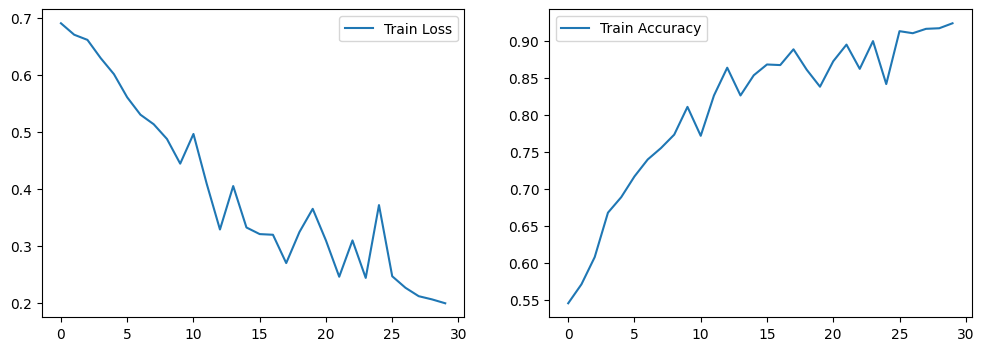

Epoch 1/30 - Loss: 0.6997, Accuracy: 0.5201
Epoch 2/30 - Loss: 0.6747, Accuracy: 0.5667
Epoch 3/30 - Loss: 0.6202, Accuracy: 0.6464
Epoch 4/30 - Loss: 0.5689, Accuracy: 0.7139
Epoch 5/30 - Loss: 0.5138, Accuracy: 0.7526
Epoch 6/30 - Loss: 0.4617, Accuracy: 0.7904
Epoch 7/30 - Loss: 0.4275, Accuracy: 0.8145
Epoch 8/30 - Loss: 0.4059, Accuracy: 0.8315
Epoch 9/30 - Loss: 0.4583, Accuracy: 0.7893
Epoch 10/30 - Loss: 0.4383, Accuracy: 0.7968
Epoch 11/30 - Loss: 0.3477, Accuracy: 0.8603
Epoch 12/30 - Loss: 0.2971, Accuracy: 0.8694
Epoch 13/30 - Loss: 0.3558, Accuracy: 0.8552
Epoch 14/30 - Loss: 0.3380, Accuracy: 0.8524
Epoch 15/30 - Loss: 0.3873, Accuracy: 0.8299
Epoch 16/30 - Loss: 0.2712, Accuracy: 0.8915
Epoch 17/30 - Loss: 0.2755, Accuracy: 0.8927
Epoch 18/30 - Loss: 0.2229, Accuracy: 0.9148
Epoch 19/30 - Loss: 0.2166, Accuracy: 0.9124
Epoch 20/30 - Loss: 0.1891, Accuracy: 0.9305
Epoch 21/30 - Loss: 0.1867, Accuracy: 0.9278
Epoch 22/30 - Loss: 0.3797, Accuracy: 0.8461
Epoch 23/30 - Loss:

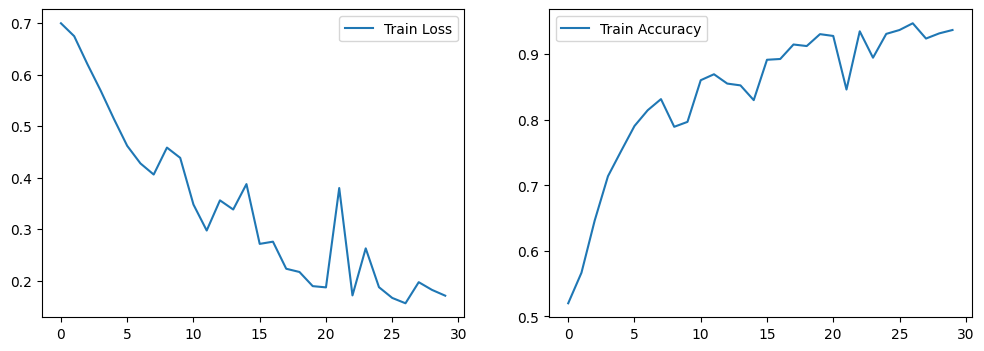

Epoch 1/30 - Loss: 0.6947, Accuracy: 0.5387
Epoch 2/30 - Loss: 0.6668, Accuracy: 0.6105
Epoch 3/30 - Loss: 0.6342, Accuracy: 0.6515
Epoch 4/30 - Loss: 0.5816, Accuracy: 0.7103
Epoch 5/30 - Loss: 0.5592, Accuracy: 0.7257
Epoch 6/30 - Loss: 0.5249, Accuracy: 0.7612
Epoch 7/30 - Loss: 0.5260, Accuracy: 0.7498
Epoch 8/30 - Loss: 0.4421, Accuracy: 0.8062
Epoch 9/30 - Loss: 0.4092, Accuracy: 0.8295
Epoch 10/30 - Loss: 0.3796, Accuracy: 0.8433
Epoch 11/30 - Loss: 0.3820, Accuracy: 0.8418
Epoch 12/30 - Loss: 0.4507, Accuracy: 0.7987
Epoch 13/30 - Loss: 0.3268, Accuracy: 0.8765
Epoch 14/30 - Loss: 0.3225, Accuracy: 0.8702
Epoch 15/30 - Loss: 0.3817, Accuracy: 0.8421
Epoch 16/30 - Loss: 0.3282, Accuracy: 0.8623
Epoch 17/30 - Loss: 0.2927, Accuracy: 0.8792
Epoch 18/30 - Loss: 0.2903, Accuracy: 0.8781
Epoch 19/30 - Loss: 0.2443, Accuracy: 0.8974
Epoch 20/30 - Loss: 0.2809, Accuracy: 0.8840
Epoch 21/30 - Loss: 0.2318, Accuracy: 0.9053
Epoch 22/30 - Loss: 0.2193, Accuracy: 0.9159
Epoch 23/30 - Loss:

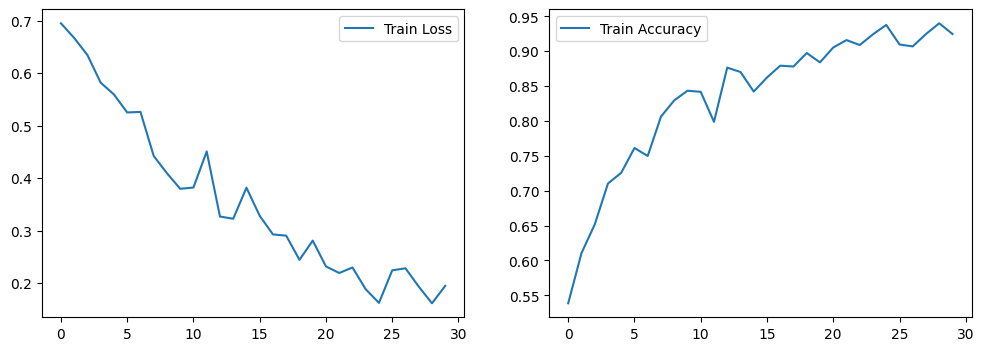

Epoch 1/30 - Loss: 0.6755, Accuracy: 0.5683
Epoch 2/30 - Loss: 0.6614, Accuracy: 0.5994
Epoch 3/30 - Loss: 0.6229, Accuracy: 0.6610
Epoch 4/30 - Loss: 0.5645, Accuracy: 0.7186
Epoch 5/30 - Loss: 0.5330, Accuracy: 0.7474
Epoch 6/30 - Loss: 0.4893, Accuracy: 0.7782
Epoch 7/30 - Loss: 0.5665, Accuracy: 0.7143
Epoch 8/30 - Loss: 0.4771, Accuracy: 0.7845
Epoch 9/30 - Loss: 0.4264, Accuracy: 0.8181
Epoch 10/30 - Loss: 0.3917, Accuracy: 0.8398
Epoch 11/30 - Loss: 0.3716, Accuracy: 0.8496
Epoch 12/30 - Loss: 0.4383, Accuracy: 0.7991
Epoch 13/30 - Loss: 0.4530, Accuracy: 0.8023
Epoch 14/30 - Loss: 0.3322, Accuracy: 0.8749
Epoch 15/30 - Loss: 0.3004, Accuracy: 0.8871
Epoch 16/30 - Loss: 0.3245, Accuracy: 0.8753
Epoch 17/30 - Loss: 0.3166, Accuracy: 0.8662
Epoch 18/30 - Loss: 0.2866, Accuracy: 0.8796
Epoch 19/30 - Loss: 0.3108, Accuracy: 0.8627
Epoch 20/30 - Loss: 0.2569, Accuracy: 0.8903
Epoch 21/30 - Loss: 0.2395, Accuracy: 0.9029
Epoch 22/30 - Loss: 0.2246, Accuracy: 0.9041
Epoch 23/30 - Loss:

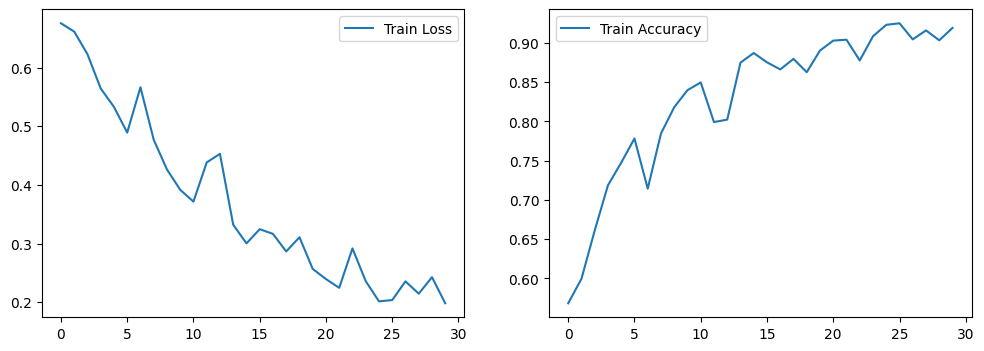


=== BatchNorm + Noise 2 ===
Epoch 1/30 - Loss: 0.7106, Accuracy: 0.5300
Epoch 2/30 - Loss: 0.6876, Accuracy: 0.5383
Epoch 3/30 - Loss: 0.6701, Accuracy: 0.5931
Epoch 4/30 - Loss: 0.6303, Accuracy: 0.6523
Epoch 5/30 - Loss: 0.6151, Accuracy: 0.6642
Epoch 6/30 - Loss: 0.5940, Accuracy: 0.6934
Epoch 7/30 - Loss: 0.5739, Accuracy: 0.7001
Epoch 8/30 - Loss: 0.5628, Accuracy: 0.7218
Epoch 9/30 - Loss: 0.4839, Accuracy: 0.7672
Epoch 10/30 - Loss: 0.4943, Accuracy: 0.7731
Epoch 11/30 - Loss: 0.4755, Accuracy: 0.7885
Epoch 12/30 - Loss: 0.4294, Accuracy: 0.8208
Epoch 13/30 - Loss: 0.3934, Accuracy: 0.8429
Epoch 14/30 - Loss: 0.3928, Accuracy: 0.8382
Epoch 15/30 - Loss: 0.3530, Accuracy: 0.8650
Epoch 16/30 - Loss: 0.3477, Accuracy: 0.8528
Epoch 17/30 - Loss: 0.3920, Accuracy: 0.8481
Epoch 18/30 - Loss: 0.2914, Accuracy: 0.8931
Epoch 19/30 - Loss: 0.3415, Accuracy: 0.8666
Epoch 20/30 - Loss: 0.2931, Accuracy: 0.8871
Epoch 21/30 - Loss: 0.3085, Accuracy: 0.8745
Epoch 22/30 - Loss: 0.2762, Accurac

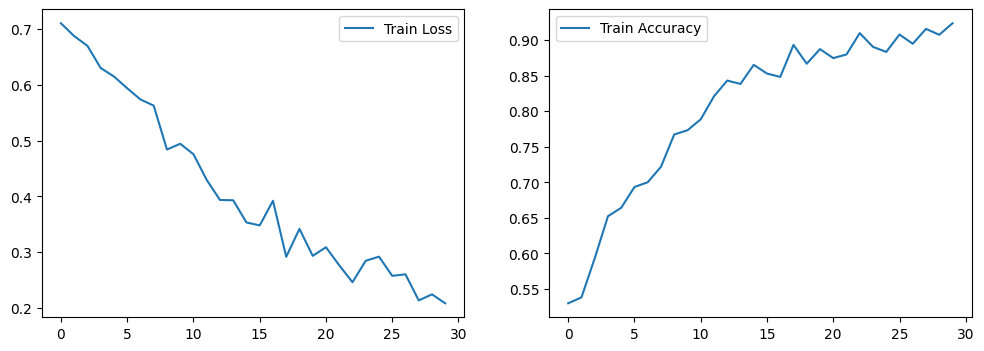

Epoch 1/30 - Loss: 0.7160, Accuracy: 0.5114
Epoch 2/30 - Loss: 0.6885, Accuracy: 0.5458
Epoch 3/30 - Loss: 0.6735, Accuracy: 0.5848
Epoch 4/30 - Loss: 0.6435, Accuracy: 0.6223
Epoch 5/30 - Loss: 0.6033, Accuracy: 0.6823
Epoch 6/30 - Loss: 0.6036, Accuracy: 0.6756
Epoch 7/30 - Loss: 0.5261, Accuracy: 0.7439
Epoch 8/30 - Loss: 0.5001, Accuracy: 0.7731
Epoch 9/30 - Loss: 0.4724, Accuracy: 0.7881
Epoch 10/30 - Loss: 0.4902, Accuracy: 0.7747
Epoch 11/30 - Loss: 0.5154, Accuracy: 0.7691
Epoch 12/30 - Loss: 0.5087, Accuracy: 0.7664
Epoch 13/30 - Loss: 0.3991, Accuracy: 0.8311
Epoch 14/30 - Loss: 0.3860, Accuracy: 0.8425
Epoch 15/30 - Loss: 0.3793, Accuracy: 0.8516
Epoch 16/30 - Loss: 0.4366, Accuracy: 0.8189
Epoch 17/30 - Loss: 0.3798, Accuracy: 0.8603
Epoch 18/30 - Loss: 0.3404, Accuracy: 0.8678
Epoch 19/30 - Loss: 0.4127, Accuracy: 0.8299
Epoch 20/30 - Loss: 0.2999, Accuracy: 0.8887
Epoch 21/30 - Loss: 0.4487, Accuracy: 0.8200
Epoch 22/30 - Loss: 0.2864, Accuracy: 0.8875
Epoch 23/30 - Loss:

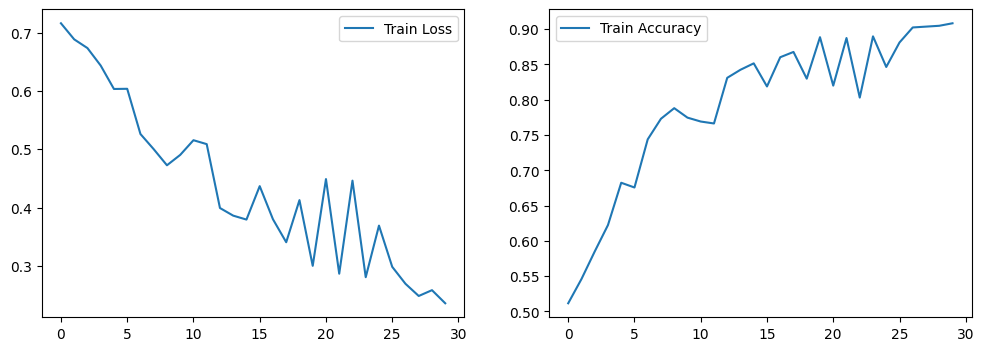

Epoch 1/30 - Loss: 0.7216, Accuracy: 0.5343
Epoch 2/30 - Loss: 0.6872, Accuracy: 0.5521
Epoch 3/30 - Loss: 0.6759, Accuracy: 0.5841
Epoch 4/30 - Loss: 0.6620, Accuracy: 0.6073
Epoch 5/30 - Loss: 0.6420, Accuracy: 0.6405
Epoch 6/30 - Loss: 0.5982, Accuracy: 0.6803
Epoch 7/30 - Loss: 0.5841, Accuracy: 0.7005
Epoch 8/30 - Loss: 0.5394, Accuracy: 0.7537
Epoch 9/30 - Loss: 0.4938, Accuracy: 0.7865
Epoch 10/30 - Loss: 0.5408, Accuracy: 0.7553
Epoch 11/30 - Loss: 0.4813, Accuracy: 0.8015
Epoch 12/30 - Loss: 0.4124, Accuracy: 0.8362
Epoch 13/30 - Loss: 0.4402, Accuracy: 0.8256
Epoch 14/30 - Loss: 0.3741, Accuracy: 0.8540
Epoch 15/30 - Loss: 0.3662, Accuracy: 0.8567
Epoch 16/30 - Loss: 0.4074, Accuracy: 0.8307
Epoch 17/30 - Loss: 0.3337, Accuracy: 0.8666
Epoch 18/30 - Loss: 0.3710, Accuracy: 0.8520
Epoch 19/30 - Loss: 0.3456, Accuracy: 0.8615
Epoch 20/30 - Loss: 0.3163, Accuracy: 0.8804
Epoch 21/30 - Loss: 0.2822, Accuracy: 0.8982
Epoch 22/30 - Loss: 0.3392, Accuracy: 0.8670
Epoch 23/30 - Loss:

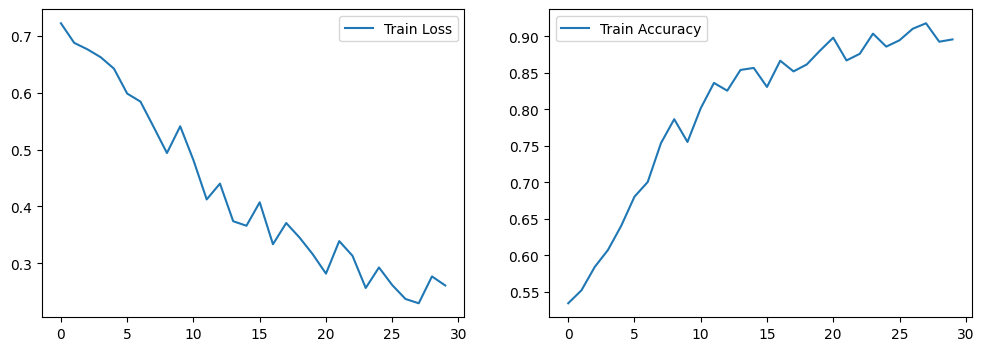

Epoch 1/30 - Loss: 0.7092, Accuracy: 0.5260
Epoch 2/30 - Loss: 0.6870, Accuracy: 0.5328
Epoch 3/30 - Loss: 0.6742, Accuracy: 0.5691
Epoch 4/30 - Loss: 0.6522, Accuracy: 0.6176
Epoch 5/30 - Loss: 0.6296, Accuracy: 0.6638
Epoch 6/30 - Loss: 0.6156, Accuracy: 0.6784
Epoch 7/30 - Loss: 0.5699, Accuracy: 0.7143
Epoch 8/30 - Loss: 0.5728, Accuracy: 0.7245
Epoch 9/30 - Loss: 0.4834, Accuracy: 0.7849
Epoch 10/30 - Loss: 0.4764, Accuracy: 0.7798
Epoch 11/30 - Loss: 0.4512, Accuracy: 0.7972
Epoch 12/30 - Loss: 0.3703, Accuracy: 0.8421
Epoch 13/30 - Loss: 0.3403, Accuracy: 0.8611
Epoch 14/30 - Loss: 0.3212, Accuracy: 0.8706
Epoch 15/30 - Loss: 0.3282, Accuracy: 0.8599
Epoch 16/30 - Loss: 0.3747, Accuracy: 0.8358
Epoch 17/30 - Loss: 0.2905, Accuracy: 0.8796
Epoch 18/30 - Loss: 0.2392, Accuracy: 0.9049
Epoch 19/30 - Loss: 0.2581, Accuracy: 0.9021
Epoch 20/30 - Loss: 0.2480, Accuracy: 0.9021
Epoch 21/30 - Loss: 0.2020, Accuracy: 0.9278
Epoch 22/30 - Loss: 0.1994, Accuracy: 0.9215
Epoch 23/30 - Loss:

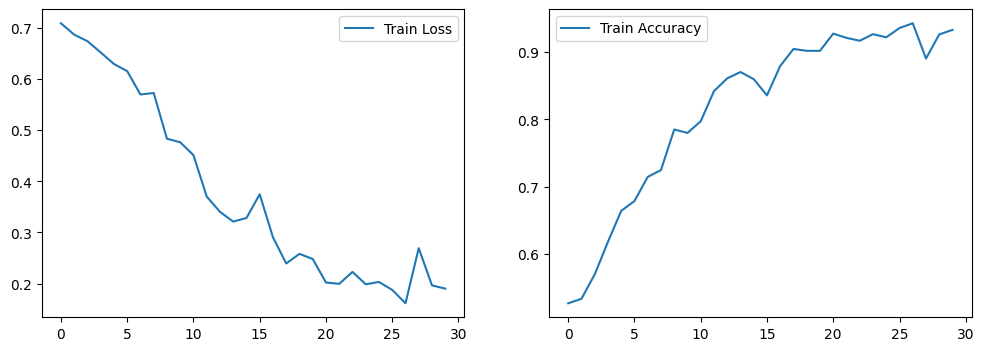

Epoch 1/30 - Loss: 0.7091, Accuracy: 0.5300
Epoch 2/30 - Loss: 0.6846, Accuracy: 0.5426
Epoch 3/30 - Loss: 0.6743, Accuracy: 0.5770
Epoch 4/30 - Loss: 0.6526, Accuracy: 0.6200
Epoch 5/30 - Loss: 0.6365, Accuracy: 0.6381
Epoch 6/30 - Loss: 0.6053, Accuracy: 0.6902
Epoch 7/30 - Loss: 0.5439, Accuracy: 0.7336
Epoch 8/30 - Loss: 0.5165, Accuracy: 0.7601
Epoch 9/30 - Loss: 0.5067, Accuracy: 0.7715
Epoch 10/30 - Loss: 0.4546, Accuracy: 0.8082
Epoch 11/30 - Loss: 0.4996, Accuracy: 0.7664
Epoch 12/30 - Loss: 0.4292, Accuracy: 0.8189
Epoch 13/30 - Loss: 0.3705, Accuracy: 0.8591
Epoch 14/30 - Loss: 0.4487, Accuracy: 0.8047
Epoch 15/30 - Loss: 0.4112, Accuracy: 0.8335
Epoch 16/30 - Loss: 0.3490, Accuracy: 0.8532
Epoch 17/30 - Loss: 0.3177, Accuracy: 0.8717
Epoch 18/30 - Loss: 0.3834, Accuracy: 0.8402
Epoch 19/30 - Loss: 0.4528, Accuracy: 0.8015
Epoch 20/30 - Loss: 0.3261, Accuracy: 0.8733
Epoch 21/30 - Loss: 0.3530, Accuracy: 0.8469
Epoch 22/30 - Loss: 0.3754, Accuracy: 0.8445
Epoch 23/30 - Loss:

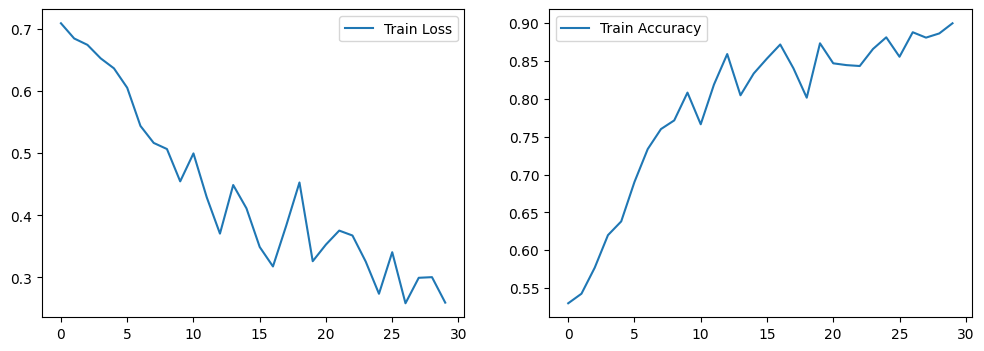

Epoch 1/30 - Loss: 0.7161, Accuracy: 0.5154
Epoch 2/30 - Loss: 0.6917, Accuracy: 0.5363
Epoch 3/30 - Loss: 0.6769, Accuracy: 0.5659
Epoch 4/30 - Loss: 0.6552, Accuracy: 0.6129
Epoch 5/30 - Loss: 0.6501, Accuracy: 0.6223
Epoch 6/30 - Loss: 0.6038, Accuracy: 0.6863
Epoch 7/30 - Loss: 0.5617, Accuracy: 0.7320
Epoch 8/30 - Loss: 0.5275, Accuracy: 0.7478
Epoch 9/30 - Loss: 0.5310, Accuracy: 0.7522
Epoch 10/30 - Loss: 0.5328, Accuracy: 0.7466
Epoch 11/30 - Loss: 0.4813, Accuracy: 0.7806
Epoch 12/30 - Loss: 0.4117, Accuracy: 0.8193
Epoch 13/30 - Loss: 0.4077, Accuracy: 0.8228
Epoch 14/30 - Loss: 0.4096, Accuracy: 0.8283
Epoch 15/30 - Loss: 0.3619, Accuracy: 0.8571
Epoch 16/30 - Loss: 0.3822, Accuracy: 0.8445
Epoch 17/30 - Loss: 0.3766, Accuracy: 0.8496
Epoch 18/30 - Loss: 0.3992, Accuracy: 0.8429
Epoch 19/30 - Loss: 0.3745, Accuracy: 0.8453
Epoch 20/30 - Loss: 0.3504, Accuracy: 0.8623
Epoch 21/30 - Loss: 0.3125, Accuracy: 0.8769
Epoch 22/30 - Loss: 0.2775, Accuracy: 0.8832
Epoch 23/30 - Loss:

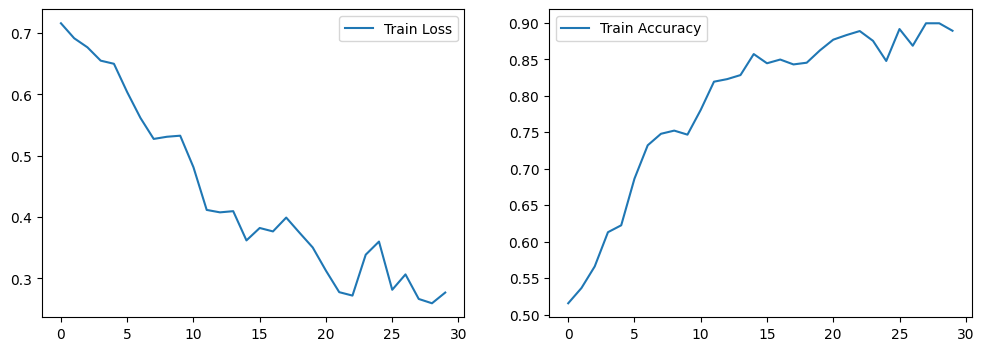

Epoch 1/30 - Loss: 0.7249, Accuracy: 0.4964
Epoch 2/30 - Loss: 0.6899, Accuracy: 0.5308
Epoch 3/30 - Loss: 0.6875, Accuracy: 0.5351
Epoch 4/30 - Loss: 0.6755, Accuracy: 0.5742
Epoch 5/30 - Loss: 0.6567, Accuracy: 0.6113
Epoch 6/30 - Loss: 0.6416, Accuracy: 0.6318
Epoch 7/30 - Loss: 0.5831, Accuracy: 0.7044
Epoch 8/30 - Loss: 0.5405, Accuracy: 0.7423
Epoch 9/30 - Loss: 0.5475, Accuracy: 0.7316
Epoch 10/30 - Loss: 0.5120, Accuracy: 0.7711
Epoch 11/30 - Loss: 0.4983, Accuracy: 0.7770
Epoch 12/30 - Loss: 0.4883, Accuracy: 0.7802
Epoch 13/30 - Loss: 0.4289, Accuracy: 0.8244
Epoch 14/30 - Loss: 0.4841, Accuracy: 0.7912
Epoch 15/30 - Loss: 0.3896, Accuracy: 0.8437
Epoch 16/30 - Loss: 0.3878, Accuracy: 0.8394
Epoch 17/30 - Loss: 0.4304, Accuracy: 0.8252
Epoch 18/30 - Loss: 0.3379, Accuracy: 0.8639
Epoch 19/30 - Loss: 0.3293, Accuracy: 0.8706
Epoch 20/30 - Loss: 0.3134, Accuracy: 0.8777
Epoch 21/30 - Loss: 0.2872, Accuracy: 0.8871
Epoch 22/30 - Loss: 0.3650, Accuracy: 0.8481
Epoch 23/30 - Loss:

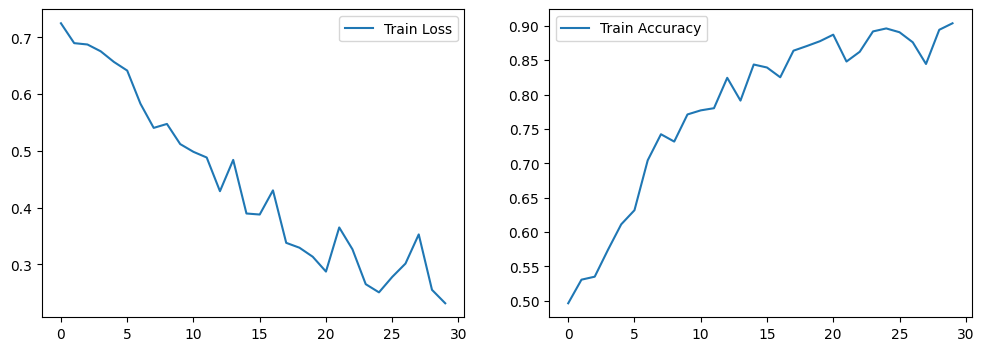

Epoch 1/30 - Loss: 0.7228, Accuracy: 0.5253
Epoch 2/30 - Loss: 0.6919, Accuracy: 0.5324
Epoch 3/30 - Loss: 0.6851, Accuracy: 0.5414
Epoch 4/30 - Loss: 0.6661, Accuracy: 0.6010
Epoch 5/30 - Loss: 0.6239, Accuracy: 0.6579
Epoch 6/30 - Loss: 0.5875, Accuracy: 0.7017
Epoch 7/30 - Loss: 0.5482, Accuracy: 0.7451
Epoch 8/30 - Loss: 0.5537, Accuracy: 0.7320
Epoch 9/30 - Loss: 0.4926, Accuracy: 0.7770
Epoch 10/30 - Loss: 0.4462, Accuracy: 0.8129
Epoch 11/30 - Loss: 0.4671, Accuracy: 0.8027
Epoch 12/30 - Loss: 0.5754, Accuracy: 0.7242
Epoch 13/30 - Loss: 0.4983, Accuracy: 0.7616
Epoch 14/30 - Loss: 0.4731, Accuracy: 0.7901
Epoch 15/30 - Loss: 0.4080, Accuracy: 0.8362
Epoch 16/30 - Loss: 0.4457, Accuracy: 0.8149
Epoch 17/30 - Loss: 0.3866, Accuracy: 0.8461
Epoch 18/30 - Loss: 0.3567, Accuracy: 0.8639
Epoch 19/30 - Loss: 0.3902, Accuracy: 0.8378
Epoch 20/30 - Loss: 0.3440, Accuracy: 0.8615
Epoch 21/30 - Loss: 0.3281, Accuracy: 0.8717
Epoch 22/30 - Loss: 0.3546, Accuracy: 0.8571
Epoch 23/30 - Loss:

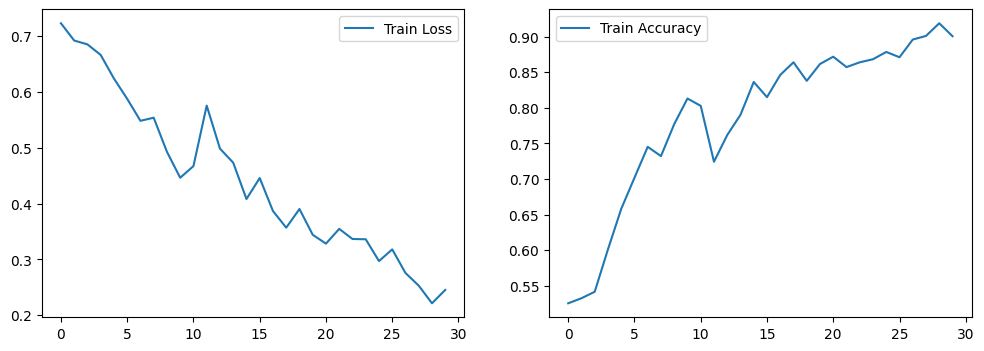

Epoch 1/30 - Loss: 0.7151, Accuracy: 0.5075
Epoch 2/30 - Loss: 0.6898, Accuracy: 0.5324
Epoch 3/30 - Loss: 0.6814, Accuracy: 0.5568
Epoch 4/30 - Loss: 0.6676, Accuracy: 0.5821
Epoch 5/30 - Loss: 0.6438, Accuracy: 0.6287
Epoch 6/30 - Loss: 0.6152, Accuracy: 0.6713
Epoch 7/30 - Loss: 0.5659, Accuracy: 0.7060
Epoch 8/30 - Loss: 0.5697, Accuracy: 0.7044
Epoch 9/30 - Loss: 0.5459, Accuracy: 0.7269
Epoch 10/30 - Loss: 0.4968, Accuracy: 0.7723
Epoch 11/30 - Loss: 0.4545, Accuracy: 0.7999
Epoch 12/30 - Loss: 0.4870, Accuracy: 0.7893
Epoch 13/30 - Loss: 0.3750, Accuracy: 0.8441
Epoch 14/30 - Loss: 0.4450, Accuracy: 0.8165
Epoch 15/30 - Loss: 0.4057, Accuracy: 0.8279
Epoch 16/30 - Loss: 0.4206, Accuracy: 0.8181
Epoch 17/30 - Loss: 0.3397, Accuracy: 0.8627
Epoch 18/30 - Loss: 0.4853, Accuracy: 0.7770
Epoch 19/30 - Loss: 0.3551, Accuracy: 0.8583
Epoch 20/30 - Loss: 0.3109, Accuracy: 0.8769
Epoch 21/30 - Loss: 0.3462, Accuracy: 0.8627
Epoch 22/30 - Loss: 0.2876, Accuracy: 0.8840
Epoch 23/30 - Loss:

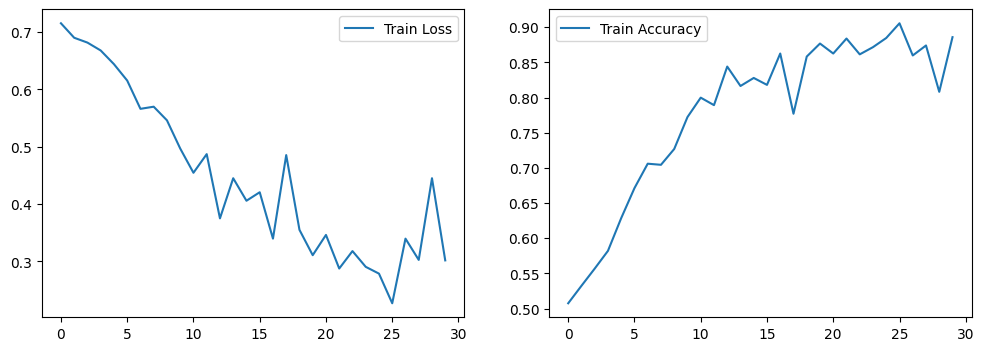

Epoch 1/30 - Loss: 0.7226, Accuracy: 0.5075
Epoch 2/30 - Loss: 0.6850, Accuracy: 0.5525
Epoch 3/30 - Loss: 0.6845, Accuracy: 0.5600
Epoch 4/30 - Loss: 0.6664, Accuracy: 0.5991
Epoch 5/30 - Loss: 0.6287, Accuracy: 0.6480
Epoch 6/30 - Loss: 0.6054, Accuracy: 0.6772
Epoch 7/30 - Loss: 0.5960, Accuracy: 0.6973
Epoch 8/30 - Loss: 0.5152, Accuracy: 0.7541
Epoch 9/30 - Loss: 0.5250, Accuracy: 0.7494
Epoch 10/30 - Loss: 0.4688, Accuracy: 0.7857
Epoch 11/30 - Loss: 0.4247, Accuracy: 0.8212
Epoch 12/30 - Loss: 0.5815, Accuracy: 0.7111
Epoch 13/30 - Loss: 0.6190, Accuracy: 0.6705
Epoch 14/30 - Loss: 0.5598, Accuracy: 0.7198
Epoch 15/30 - Loss: 0.5129, Accuracy: 0.7636
Epoch 16/30 - Loss: 0.4297, Accuracy: 0.8216
Epoch 17/30 - Loss: 0.3937, Accuracy: 0.8473
Epoch 18/30 - Loss: 0.3492, Accuracy: 0.8583
Epoch 19/30 - Loss: 0.3668, Accuracy: 0.8500
Epoch 20/30 - Loss: 0.3255, Accuracy: 0.8694
Epoch 21/30 - Loss: 0.3320, Accuracy: 0.8678
Epoch 22/30 - Loss: 0.3277, Accuracy: 0.8662
Epoch 23/30 - Loss:

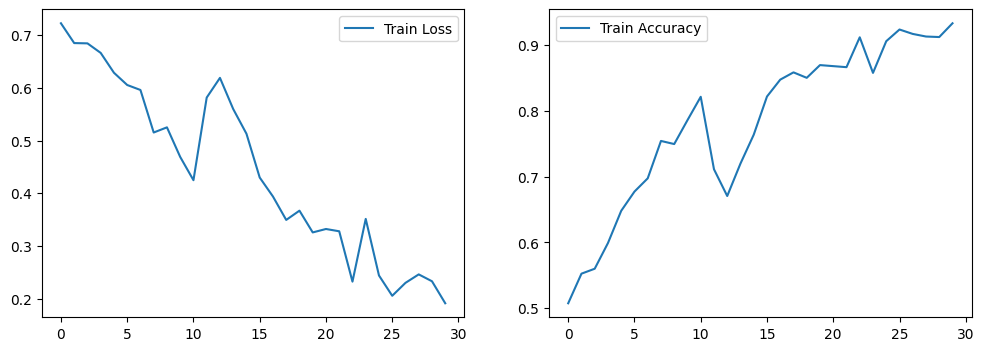


=== BatchNorm ===
Epoch 1/30 - Loss: 0.6479, Accuracy: 0.6433
Epoch 2/30 - Loss: 0.5669, Accuracy: 0.7198
Epoch 3/30 - Loss: 0.5451, Accuracy: 0.7522
Epoch 4/30 - Loss: 0.4702, Accuracy: 0.7908
Epoch 5/30 - Loss: 0.3876, Accuracy: 0.8414
Epoch 6/30 - Loss: 0.3333, Accuracy: 0.8674
Epoch 7/30 - Loss: 0.3021, Accuracy: 0.8867
Epoch 8/30 - Loss: 0.2589, Accuracy: 0.8986
Epoch 9/30 - Loss: 0.2387, Accuracy: 0.9116
Epoch 10/30 - Loss: 0.3057, Accuracy: 0.8982
Epoch 11/30 - Loss: 0.2492, Accuracy: 0.9069
Epoch 12/30 - Loss: 0.2001, Accuracy: 0.9238
Epoch 13/30 - Loss: 0.1708, Accuracy: 0.9412
Epoch 14/30 - Loss: 0.1465, Accuracy: 0.9519
Epoch 15/30 - Loss: 0.2160, Accuracy: 0.9242
Epoch 16/30 - Loss: 0.1749, Accuracy: 0.9408
Epoch 17/30 - Loss: 0.1797, Accuracy: 0.9349
Epoch 18/30 - Loss: 0.1500, Accuracy: 0.9483
Epoch 19/30 - Loss: 0.1426, Accuracy: 0.9495
Epoch 20/30 - Loss: 0.1579, Accuracy: 0.9432
Epoch 21/30 - Loss: 0.1470, Accuracy: 0.9499
Epoch 22/30 - Loss: 0.1427, Accuracy: 0.9519


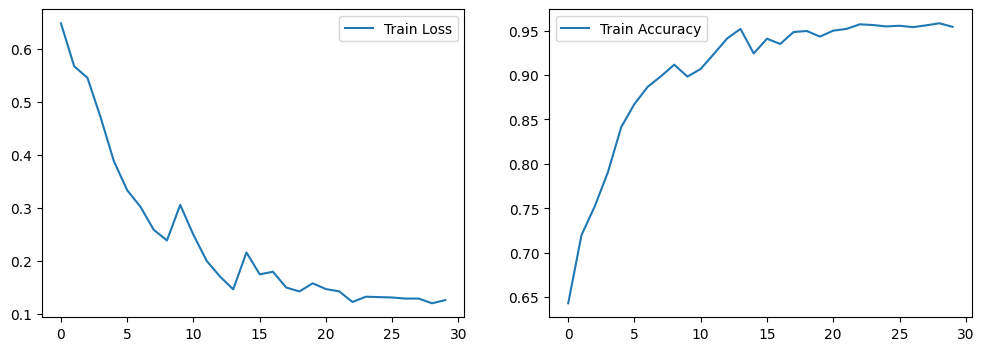

Epoch 1/30 - Loss: 0.6484, Accuracy: 0.6306
Epoch 2/30 - Loss: 0.5276, Accuracy: 0.7470
Epoch 3/30 - Loss: 0.4505, Accuracy: 0.8062
Epoch 4/30 - Loss: 0.3555, Accuracy: 0.8635
Epoch 5/30 - Loss: 0.3788, Accuracy: 0.8639
Epoch 6/30 - Loss: 0.3974, Accuracy: 0.8595
Epoch 7/30 - Loss: 0.4220, Accuracy: 0.8508
Epoch 8/30 - Loss: 0.4200, Accuracy: 0.8374
Epoch 9/30 - Loss: 0.3753, Accuracy: 0.8639
Epoch 10/30 - Loss: 0.3385, Accuracy: 0.8678
Epoch 11/30 - Loss: 0.3788, Accuracy: 0.8516
Epoch 12/30 - Loss: 0.3257, Accuracy: 0.8946
Epoch 13/30 - Loss: 0.2510, Accuracy: 0.9073
Epoch 14/30 - Loss: 0.2629, Accuracy: 0.9120
Epoch 15/30 - Loss: 0.2182, Accuracy: 0.9136
Epoch 16/30 - Loss: 0.2021, Accuracy: 0.9274
Epoch 17/30 - Loss: 0.2777, Accuracy: 0.9006
Epoch 18/30 - Loss: 0.2786, Accuracy: 0.8934
Epoch 19/30 - Loss: 0.1783, Accuracy: 0.9416
Epoch 20/30 - Loss: 0.1900, Accuracy: 0.9305
Epoch 21/30 - Loss: 0.2877, Accuracy: 0.9238
Epoch 22/30 - Loss: 0.2349, Accuracy: 0.9234
Epoch 23/30 - Loss:

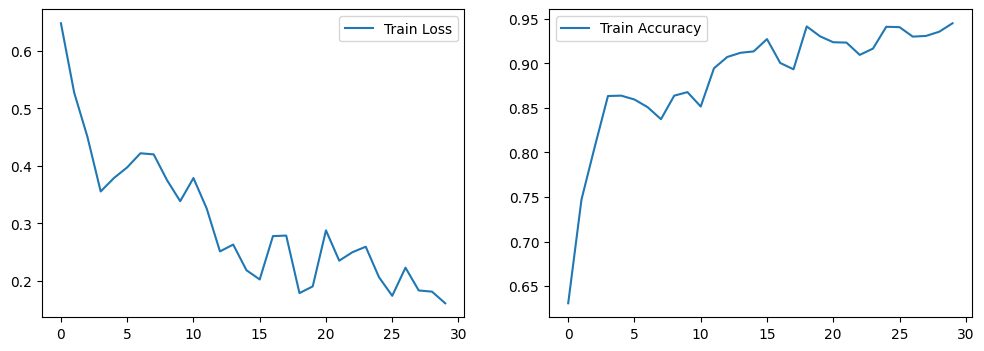

Epoch 1/30 - Loss: 0.5994, Accuracy: 0.6894
Epoch 2/30 - Loss: 0.4666, Accuracy: 0.7857
Epoch 3/30 - Loss: 0.4287, Accuracy: 0.8173
Epoch 4/30 - Loss: 0.4323, Accuracy: 0.8173
Epoch 5/30 - Loss: 0.3704, Accuracy: 0.8579
Epoch 6/30 - Loss: 0.3030, Accuracy: 0.8765
Epoch 7/30 - Loss: 0.2632, Accuracy: 0.8812
Epoch 8/30 - Loss: 0.2200, Accuracy: 0.9025
Epoch 9/30 - Loss: 0.1737, Accuracy: 0.9396
Epoch 10/30 - Loss: 0.1861, Accuracy: 0.9301
Epoch 11/30 - Loss: 0.1619, Accuracy: 0.9369
Epoch 12/30 - Loss: 0.1828, Accuracy: 0.9301
Epoch 13/30 - Loss: 0.1662, Accuracy: 0.9392
Epoch 14/30 - Loss: 0.1361, Accuracy: 0.9515
Epoch 15/30 - Loss: 0.1282, Accuracy: 0.9578
Epoch 16/30 - Loss: 0.1604, Accuracy: 0.9384
Epoch 17/30 - Loss: 0.1331, Accuracy: 0.9550
Epoch 18/30 - Loss: 0.1618, Accuracy: 0.9396
Epoch 19/30 - Loss: 0.1646, Accuracy: 0.9396
Epoch 20/30 - Loss: 0.1302, Accuracy: 0.9550
Epoch 21/30 - Loss: 0.1416, Accuracy: 0.9463
Epoch 22/30 - Loss: 0.1423, Accuracy: 0.9503
Epoch 23/30 - Loss:

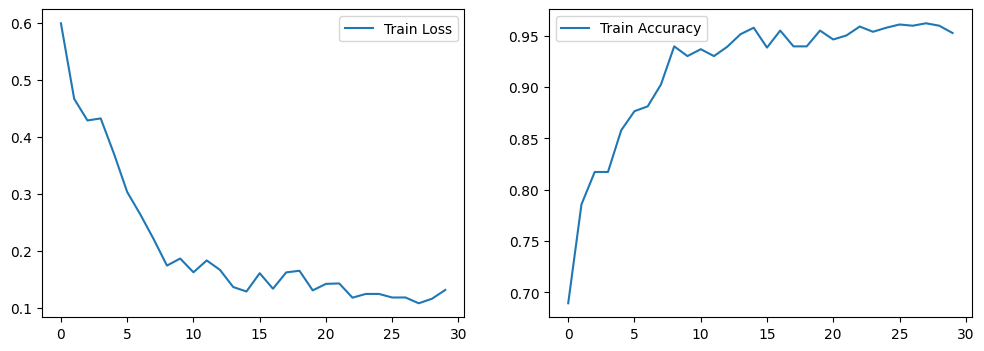

Epoch 1/30 - Loss: 0.6855, Accuracy: 0.5963
Epoch 2/30 - Loss: 0.6095, Accuracy: 0.6875
Epoch 3/30 - Loss: 0.5206, Accuracy: 0.7628
Epoch 4/30 - Loss: 0.5150, Accuracy: 0.7526
Epoch 5/30 - Loss: 0.4353, Accuracy: 0.8149
Epoch 6/30 - Loss: 0.3731, Accuracy: 0.8402
Epoch 7/30 - Loss: 0.3748, Accuracy: 0.8560
Epoch 8/30 - Loss: 0.3414, Accuracy: 0.8729
Epoch 9/30 - Loss: 0.2520, Accuracy: 0.9002
Epoch 10/30 - Loss: 0.2197, Accuracy: 0.9104
Epoch 11/30 - Loss: 0.2299, Accuracy: 0.9124
Epoch 12/30 - Loss: 0.2331, Accuracy: 0.9112
Epoch 13/30 - Loss: 0.2038, Accuracy: 0.9191
Epoch 14/30 - Loss: 0.1671, Accuracy: 0.9365
Epoch 15/30 - Loss: 0.1555, Accuracy: 0.9444
Epoch 16/30 - Loss: 0.1317, Accuracy: 0.9515
Epoch 17/30 - Loss: 0.1231, Accuracy: 0.9570
Epoch 18/30 - Loss: 0.1237, Accuracy: 0.9534
Epoch 19/30 - Loss: 0.1148, Accuracy: 0.9578
Epoch 20/30 - Loss: 0.1245, Accuracy: 0.9515
Epoch 21/30 - Loss: 0.1344, Accuracy: 0.9487
Epoch 22/30 - Loss: 0.1298, Accuracy: 0.9542
Epoch 23/30 - Loss:

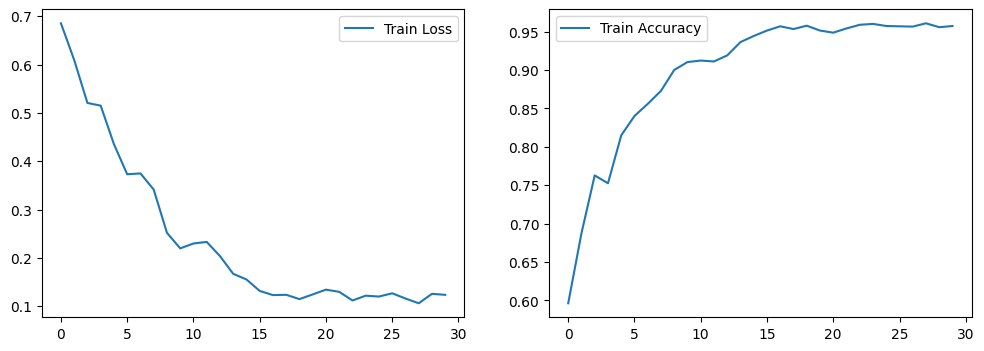

Epoch 1/30 - Loss: 0.6416, Accuracy: 0.6594
Epoch 2/30 - Loss: 0.5492, Accuracy: 0.7293
Epoch 3/30 - Loss: 0.4942, Accuracy: 0.7743
Epoch 4/30 - Loss: 0.4011, Accuracy: 0.8536
Epoch 5/30 - Loss: 0.3707, Accuracy: 0.8477
Epoch 6/30 - Loss: 0.3450, Accuracy: 0.8721
Epoch 7/30 - Loss: 0.3657, Accuracy: 0.8619
Epoch 8/30 - Loss: 0.2162, Accuracy: 0.9175
Epoch 9/30 - Loss: 0.3688, Accuracy: 0.8615
Epoch 10/30 - Loss: 0.3643, Accuracy: 0.8891
Epoch 11/30 - Loss: 0.1992, Accuracy: 0.9242
Epoch 12/30 - Loss: 0.2127, Accuracy: 0.9203
Epoch 13/30 - Loss: 0.1710, Accuracy: 0.9396
Epoch 14/30 - Loss: 0.1985, Accuracy: 0.9396
Epoch 15/30 - Loss: 0.1710, Accuracy: 0.9448
Epoch 16/30 - Loss: 0.1686, Accuracy: 0.9408
Epoch 17/30 - Loss: 0.1589, Accuracy: 0.9455
Epoch 18/30 - Loss: 0.1525, Accuracy: 0.9503
Epoch 19/30 - Loss: 0.1442, Accuracy: 0.9503
Epoch 20/30 - Loss: 0.1400, Accuracy: 0.9534
Epoch 21/30 - Loss: 0.1339, Accuracy: 0.9558
Epoch 22/30 - Loss: 0.1388, Accuracy: 0.9515
Epoch 23/30 - Loss:

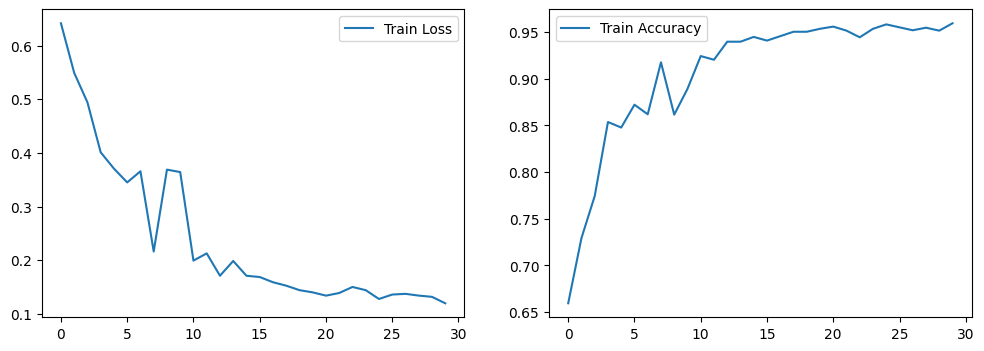

Epoch 1/30 - Loss: 0.6362, Accuracy: 0.6046
Epoch 2/30 - Loss: 0.5408, Accuracy: 0.7427
Epoch 3/30 - Loss: 0.4536, Accuracy: 0.8074
Epoch 4/30 - Loss: 0.4396, Accuracy: 0.8268
Epoch 5/30 - Loss: 0.3211, Accuracy: 0.8863
Epoch 6/30 - Loss: 0.2980, Accuracy: 0.8958
Epoch 7/30 - Loss: 0.2349, Accuracy: 0.9088
Epoch 8/30 - Loss: 0.2188, Accuracy: 0.9179
Epoch 9/30 - Loss: 0.2032, Accuracy: 0.9266
Epoch 10/30 - Loss: 0.1981, Accuracy: 0.9258
Epoch 11/30 - Loss: 0.1803, Accuracy: 0.9357
Epoch 12/30 - Loss: 0.1606, Accuracy: 0.9428
Epoch 13/30 - Loss: 0.1632, Accuracy: 0.9432
Epoch 14/30 - Loss: 0.1750, Accuracy: 0.9428
Epoch 15/30 - Loss: 0.2586, Accuracy: 0.9061
Epoch 16/30 - Loss: 0.2297, Accuracy: 0.9136
Epoch 17/30 - Loss: 0.1924, Accuracy: 0.9329
Epoch 18/30 - Loss: 0.1548, Accuracy: 0.9491
Epoch 19/30 - Loss: 0.1420, Accuracy: 0.9515
Epoch 20/30 - Loss: 0.1602, Accuracy: 0.9412
Epoch 21/30 - Loss: 0.1600, Accuracy: 0.9428
Epoch 22/30 - Loss: 0.1433, Accuracy: 0.9451
Epoch 23/30 - Loss:

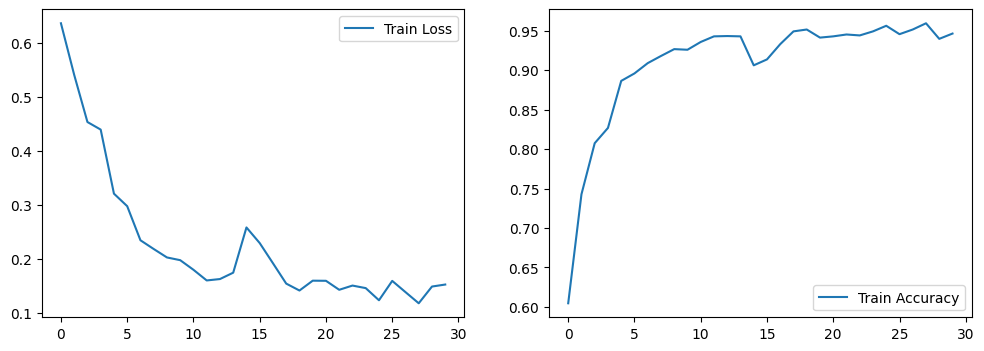

Epoch 1/30 - Loss: 0.6059, Accuracy: 0.6851
Epoch 2/30 - Loss: 0.5330, Accuracy: 0.7332
Epoch 3/30 - Loss: 0.4923, Accuracy: 0.7739
Epoch 4/30 - Loss: 0.4521, Accuracy: 0.8078
Epoch 5/30 - Loss: 0.3834, Accuracy: 0.8485
Epoch 6/30 - Loss: 0.3816, Accuracy: 0.8642
Epoch 7/30 - Loss: 0.3113, Accuracy: 0.8788
Epoch 8/30 - Loss: 0.3129, Accuracy: 0.8792
Epoch 9/30 - Loss: 0.2416, Accuracy: 0.9033
Epoch 10/30 - Loss: 0.2147, Accuracy: 0.9195
Epoch 11/30 - Loss: 0.2066, Accuracy: 0.9167
Epoch 12/30 - Loss: 0.1868, Accuracy: 0.9290
Epoch 13/30 - Loss: 0.1677, Accuracy: 0.9380
Epoch 14/30 - Loss: 0.2027, Accuracy: 0.9282
Epoch 15/30 - Loss: 0.2443, Accuracy: 0.9163
Epoch 16/30 - Loss: 0.2195, Accuracy: 0.9262
Epoch 17/30 - Loss: 0.2137, Accuracy: 0.9199
Epoch 18/30 - Loss: 0.3792, Accuracy: 0.9116
Epoch 19/30 - Loss: 0.2167, Accuracy: 0.9254
Epoch 20/30 - Loss: 0.1610, Accuracy: 0.9483
Epoch 21/30 - Loss: 0.1354, Accuracy: 0.9550
Epoch 22/30 - Loss: 0.1451, Accuracy: 0.9519
Epoch 23/30 - Loss:

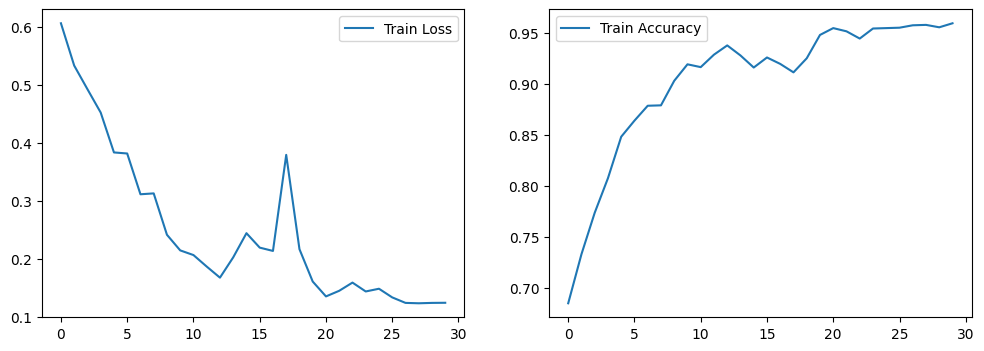

Epoch 1/30 - Loss: 0.6051, Accuracy: 0.6878
Epoch 2/30 - Loss: 0.4769, Accuracy: 0.7727
Epoch 3/30 - Loss: 0.4452, Accuracy: 0.8122
Epoch 4/30 - Loss: 0.3999, Accuracy: 0.8374
Epoch 5/30 - Loss: 0.4406, Accuracy: 0.8295
Epoch 6/30 - Loss: 0.3322, Accuracy: 0.8741
Epoch 7/30 - Loss: 0.3150, Accuracy: 0.8852
Epoch 8/30 - Loss: 0.3834, Accuracy: 0.8895
Epoch 9/30 - Loss: 0.2957, Accuracy: 0.8982
Epoch 10/30 - Loss: 0.1995, Accuracy: 0.9333
Epoch 11/30 - Loss: 0.1474, Accuracy: 0.9550
Epoch 12/30 - Loss: 0.1801, Accuracy: 0.9392
Epoch 13/30 - Loss: 0.1474, Accuracy: 0.9432
Epoch 14/30 - Loss: 0.1721, Accuracy: 0.9365
Epoch 15/30 - Loss: 0.1644, Accuracy: 0.9424
Epoch 16/30 - Loss: 0.1466, Accuracy: 0.9448
Epoch 17/30 - Loss: 0.1321, Accuracy: 0.9534
Epoch 18/30 - Loss: 0.1206, Accuracy: 0.9566
Epoch 19/30 - Loss: 0.1202, Accuracy: 0.9609
Epoch 20/30 - Loss: 0.1665, Accuracy: 0.9353
Epoch 21/30 - Loss: 0.1259, Accuracy: 0.9594
Epoch 22/30 - Loss: 0.1487, Accuracy: 0.9487
Epoch 23/30 - Loss:

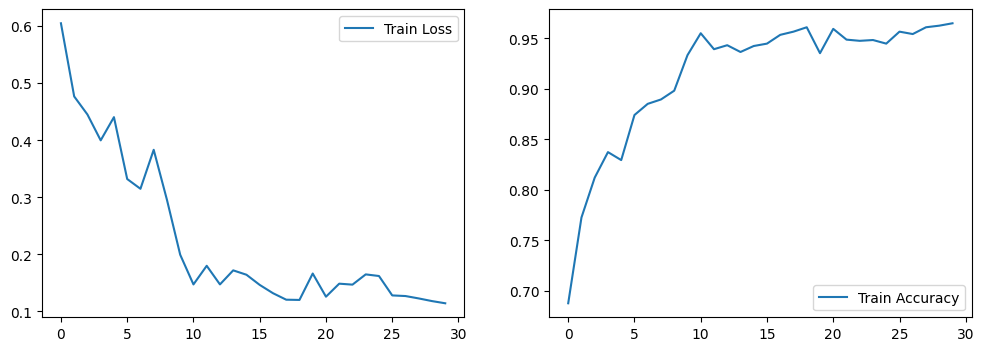

Epoch 1/30 - Loss: 0.6444, Accuracy: 0.6373
Epoch 2/30 - Loss: 0.5382, Accuracy: 0.7360
Epoch 3/30 - Loss: 0.4564, Accuracy: 0.7893
Epoch 4/30 - Loss: 0.4680, Accuracy: 0.8062
Epoch 5/30 - Loss: 0.3933, Accuracy: 0.8331
Epoch 6/30 - Loss: 0.3409, Accuracy: 0.8642
Epoch 7/30 - Loss: 0.3524, Accuracy: 0.8710
Epoch 8/30 - Loss: 0.3077, Accuracy: 0.8856
Epoch 9/30 - Loss: 0.3214, Accuracy: 0.8828
Epoch 10/30 - Loss: 0.2997, Accuracy: 0.8875
Epoch 11/30 - Loss: 0.2449, Accuracy: 0.9029
Epoch 12/30 - Loss: 0.2304, Accuracy: 0.9081
Epoch 13/30 - Loss: 0.2316, Accuracy: 0.9041
Epoch 14/30 - Loss: 0.2320, Accuracy: 0.9053
Epoch 15/30 - Loss: 0.2079, Accuracy: 0.9163
Epoch 16/30 - Loss: 0.1805, Accuracy: 0.9345
Epoch 17/30 - Loss: 0.1652, Accuracy: 0.9455
Epoch 18/30 - Loss: 0.1565, Accuracy: 0.9424
Epoch 19/30 - Loss: 0.1525, Accuracy: 0.9491
Epoch 20/30 - Loss: 0.1364, Accuracy: 0.9538
Epoch 21/30 - Loss: 0.1509, Accuracy: 0.9455
Epoch 22/30 - Loss: 0.1334, Accuracy: 0.9522
Epoch 23/30 - Loss:

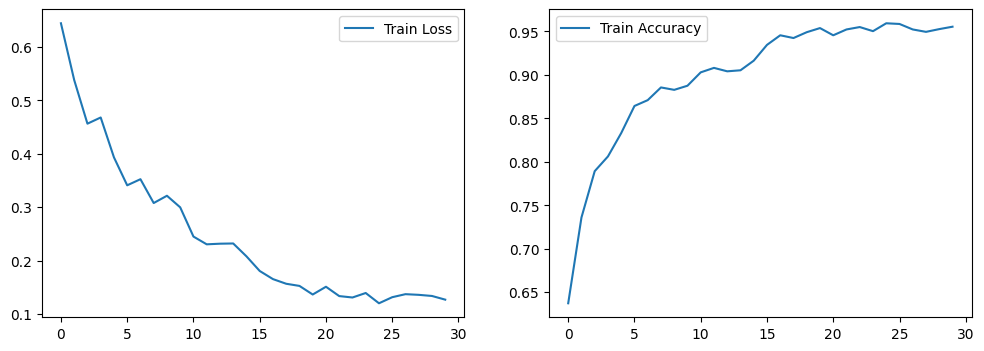

Epoch 1/30 - Loss: 0.6299, Accuracy: 0.6634
Epoch 2/30 - Loss: 0.4938, Accuracy: 0.7719
Epoch 3/30 - Loss: 0.4356, Accuracy: 0.8090
Epoch 4/30 - Loss: 0.3961, Accuracy: 0.8441
Epoch 5/30 - Loss: 0.3438, Accuracy: 0.8666
Epoch 6/30 - Loss: 0.3644, Accuracy: 0.8650
Epoch 7/30 - Loss: 0.2821, Accuracy: 0.8891
Epoch 8/30 - Loss: 0.2968, Accuracy: 0.8788
Epoch 9/30 - Loss: 0.2166, Accuracy: 0.9152
Epoch 10/30 - Loss: 0.2100, Accuracy: 0.9238
Epoch 11/30 - Loss: 0.2076, Accuracy: 0.9187
Epoch 12/30 - Loss: 0.1780, Accuracy: 0.9365
Epoch 13/30 - Loss: 0.2051, Accuracy: 0.9183
Epoch 14/30 - Loss: 0.1535, Accuracy: 0.9467
Epoch 15/30 - Loss: 0.1689, Accuracy: 0.9388
Epoch 16/30 - Loss: 0.1543, Accuracy: 0.9424
Epoch 17/30 - Loss: 0.1666, Accuracy: 0.9416
Epoch 18/30 - Loss: 0.1391, Accuracy: 0.9507
Epoch 19/30 - Loss: 0.1322, Accuracy: 0.9499
Epoch 20/30 - Loss: 0.1451, Accuracy: 0.9495
Epoch 21/30 - Loss: 0.1424, Accuracy: 0.9526
Epoch 22/30 - Loss: 0.1256, Accuracy: 0.9562
Epoch 23/30 - Loss:

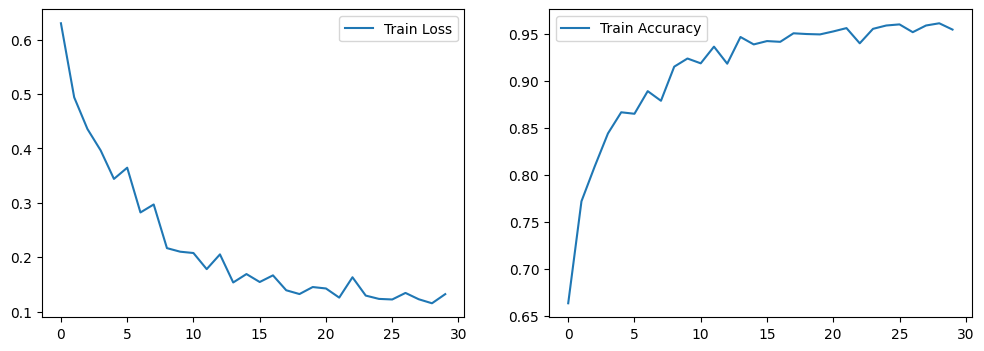


=== No BatchNorm ===
Epoch 1/30 - Loss: 0.6917, Accuracy: 0.5379
Epoch 2/30 - Loss: 0.6333, Accuracy: 0.6701
Epoch 3/30 - Loss: 0.5566, Accuracy: 0.7159
Epoch 4/30 - Loss: 0.5145, Accuracy: 0.7577
Epoch 5/30 - Loss: 0.4945, Accuracy: 0.7526
Epoch 6/30 - Loss: 0.4698, Accuracy: 0.7798
Epoch 7/30 - Loss: 0.4384, Accuracy: 0.7979
Epoch 8/30 - Loss: 0.4200, Accuracy: 0.8295
Epoch 9/30 - Loss: 0.3978, Accuracy: 0.8378
Epoch 10/30 - Loss: 0.3689, Accuracy: 0.8524
Epoch 11/30 - Loss: 0.3625, Accuracy: 0.8552
Epoch 12/30 - Loss: 0.3915, Accuracy: 0.8406
Epoch 13/30 - Loss: 0.3121, Accuracy: 0.8863
Epoch 14/30 - Loss: 0.2795, Accuracy: 0.8907
Epoch 15/30 - Loss: 0.2651, Accuracy: 0.8958
Epoch 16/30 - Loss: 0.2329, Accuracy: 0.9096
Epoch 17/30 - Loss: 0.2284, Accuracy: 0.9100
Epoch 18/30 - Loss: 0.2185, Accuracy: 0.9171
Epoch 19/30 - Loss: 0.2139, Accuracy: 0.9148
Epoch 20/30 - Loss: 0.2003, Accuracy: 0.9203
Epoch 21/30 - Loss: 0.1882, Accuracy: 0.9325
Epoch 22/30 - Loss: 0.1942, Accuracy: 0.92

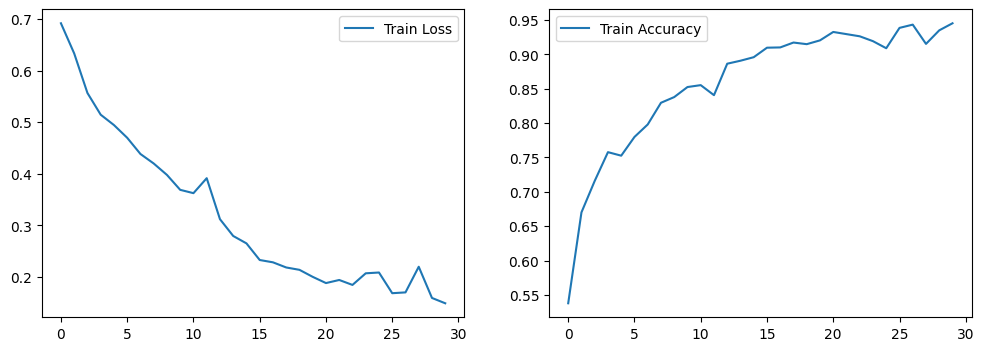

Epoch 1/30 - Loss: 0.6913, Accuracy: 0.5166
Epoch 2/30 - Loss: 0.6852, Accuracy: 0.5963
Epoch 3/30 - Loss: 0.6381, Accuracy: 0.6326
Epoch 4/30 - Loss: 0.5686, Accuracy: 0.7143
Epoch 5/30 - Loss: 0.4988, Accuracy: 0.7735
Epoch 6/30 - Loss: 0.4623, Accuracy: 0.7999
Epoch 7/30 - Loss: 0.4308, Accuracy: 0.8137
Epoch 8/30 - Loss: 0.3892, Accuracy: 0.8457
Epoch 9/30 - Loss: 0.3664, Accuracy: 0.8544
Epoch 10/30 - Loss: 0.3663, Accuracy: 0.8552
Epoch 11/30 - Loss: 0.3409, Accuracy: 0.8757
Epoch 12/30 - Loss: 0.3113, Accuracy: 0.8848
Epoch 13/30 - Loss: 0.3021, Accuracy: 0.8903
Epoch 14/30 - Loss: 0.3374, Accuracy: 0.8670
Epoch 15/30 - Loss: 0.3036, Accuracy: 0.8883
Epoch 16/30 - Loss: 0.2802, Accuracy: 0.8950
Epoch 17/30 - Loss: 0.2934, Accuracy: 0.8891
Epoch 18/30 - Loss: 0.2635, Accuracy: 0.9002
Epoch 19/30 - Loss: 0.2486, Accuracy: 0.9017
Epoch 20/30 - Loss: 0.2407, Accuracy: 0.9092
Epoch 21/30 - Loss: 0.2384, Accuracy: 0.9104
Epoch 22/30 - Loss: 0.2733, Accuracy: 0.8883
Epoch 23/30 - Loss:

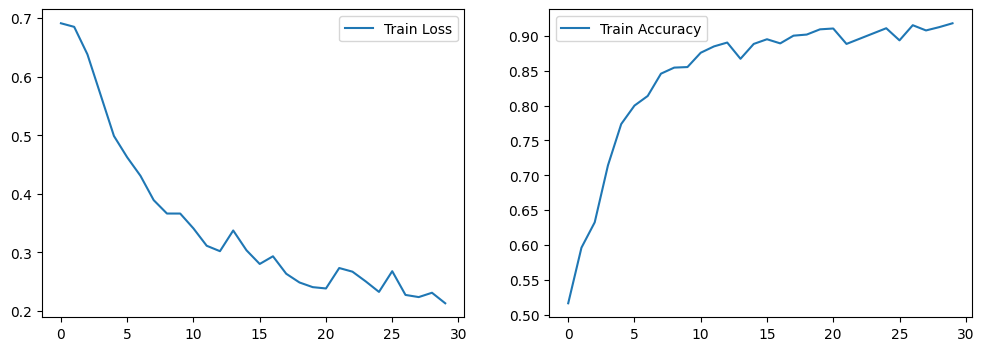

Epoch 1/30 - Loss: 0.6838, Accuracy: 0.5225
Epoch 2/30 - Loss: 0.6086, Accuracy: 0.6657
Epoch 3/30 - Loss: 0.5489, Accuracy: 0.7143
Epoch 4/30 - Loss: 0.5263, Accuracy: 0.7297
Epoch 5/30 - Loss: 0.4702, Accuracy: 0.7751
Epoch 6/30 - Loss: 0.4477, Accuracy: 0.7853
Epoch 7/30 - Loss: 0.4255, Accuracy: 0.8086
Epoch 8/30 - Loss: 0.4098, Accuracy: 0.8189
Epoch 9/30 - Loss: 0.3831, Accuracy: 0.8398
Epoch 10/30 - Loss: 0.3588, Accuracy: 0.8595
Epoch 11/30 - Loss: 0.3488, Accuracy: 0.8631
Epoch 12/30 - Loss: 0.3477, Accuracy: 0.8453
Epoch 13/30 - Loss: 0.3390, Accuracy: 0.8591
Epoch 14/30 - Loss: 0.3412, Accuracy: 0.8591
Epoch 15/30 - Loss: 0.4131, Accuracy: 0.8114
Epoch 16/30 - Loss: 0.3222, Accuracy: 0.8674
Epoch 17/30 - Loss: 0.3039, Accuracy: 0.8848
Epoch 18/30 - Loss: 0.3022, Accuracy: 0.8777
Epoch 19/30 - Loss: 0.2838, Accuracy: 0.8887
Epoch 20/30 - Loss: 0.2763, Accuracy: 0.8982
Epoch 21/30 - Loss: 0.2789, Accuracy: 0.8946
Epoch 22/30 - Loss: 0.2912, Accuracy: 0.8990
Epoch 23/30 - Loss:

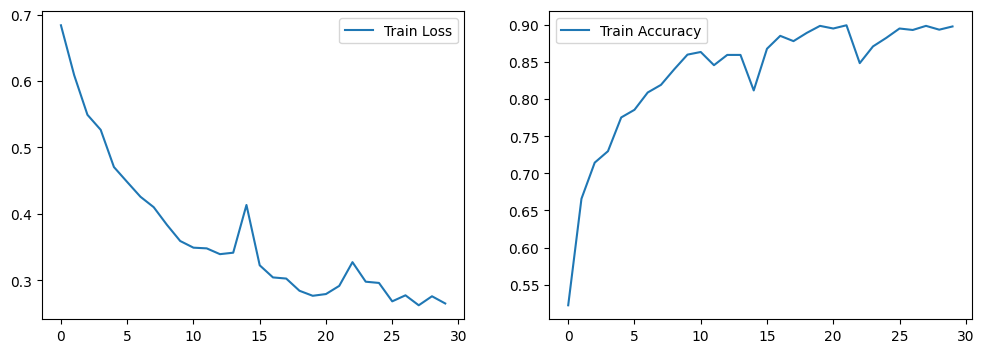

Epoch 1/30 - Loss: 0.6820, Accuracy: 0.5406
Epoch 2/30 - Loss: 0.6330, Accuracy: 0.6610
Epoch 3/30 - Loss: 0.5898, Accuracy: 0.7048
Epoch 4/30 - Loss: 0.5144, Accuracy: 0.7534
Epoch 5/30 - Loss: 0.4842, Accuracy: 0.7676
Epoch 6/30 - Loss: 0.4417, Accuracy: 0.8019
Epoch 7/30 - Loss: 0.4211, Accuracy: 0.8141
Epoch 8/30 - Loss: 0.4148, Accuracy: 0.8157
Epoch 9/30 - Loss: 0.4016, Accuracy: 0.8252
Epoch 10/30 - Loss: 0.4014, Accuracy: 0.8193
Epoch 11/30 - Loss: 0.3623, Accuracy: 0.8429
Epoch 12/30 - Loss: 0.3487, Accuracy: 0.8524
Epoch 13/30 - Loss: 0.3303, Accuracy: 0.8654
Epoch 14/30 - Loss: 0.3127, Accuracy: 0.8832
Epoch 15/30 - Loss: 0.3093, Accuracy: 0.8812
Epoch 16/30 - Loss: 0.3020, Accuracy: 0.8856
Epoch 17/30 - Loss: 0.2873, Accuracy: 0.8911
Epoch 18/30 - Loss: 0.2838, Accuracy: 0.8907
Epoch 19/30 - Loss: 0.2847, Accuracy: 0.8942
Epoch 20/30 - Loss: 0.2750, Accuracy: 0.8946
Epoch 21/30 - Loss: 0.2814, Accuracy: 0.8954
Epoch 22/30 - Loss: 0.2594, Accuracy: 0.9041
Epoch 23/30 - Loss:

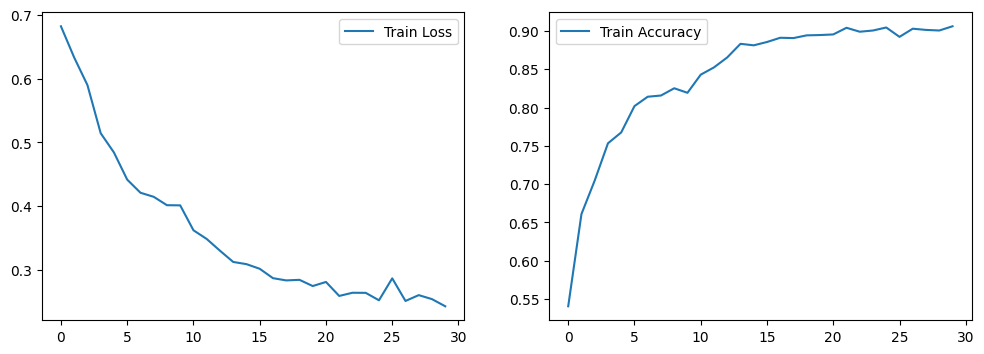

Epoch 1/30 - Loss: 0.6844, Accuracy: 0.5462
Epoch 2/30 - Loss: 0.6178, Accuracy: 0.6511
Epoch 3/30 - Loss: 0.5695, Accuracy: 0.7017
Epoch 4/30 - Loss: 0.5253, Accuracy: 0.7230
Epoch 5/30 - Loss: 0.4916, Accuracy: 0.7545
Epoch 6/30 - Loss: 0.4650, Accuracy: 0.7778
Epoch 7/30 - Loss: 0.4578, Accuracy: 0.7818
Epoch 8/30 - Loss: 0.4352, Accuracy: 0.8019
Epoch 9/30 - Loss: 0.4047, Accuracy: 0.8197
Epoch 10/30 - Loss: 0.3813, Accuracy: 0.8425
Epoch 11/30 - Loss: 0.3708, Accuracy: 0.8477
Epoch 12/30 - Loss: 0.3747, Accuracy: 0.8358
Epoch 13/30 - Loss: 0.3382, Accuracy: 0.8575
Epoch 14/30 - Loss: 0.3369, Accuracy: 0.8682
Epoch 15/30 - Loss: 0.3203, Accuracy: 0.8792
Epoch 16/30 - Loss: 0.3099, Accuracy: 0.8769
Epoch 17/30 - Loss: 0.3045, Accuracy: 0.8788
Epoch 18/30 - Loss: 0.2871, Accuracy: 0.8942
Epoch 19/30 - Loss: 0.2938, Accuracy: 0.8946
Epoch 20/30 - Loss: 0.2769, Accuracy: 0.8982
Epoch 21/30 - Loss: 0.2714, Accuracy: 0.8998
Epoch 22/30 - Loss: 0.2926, Accuracy: 0.8828
Epoch 23/30 - Loss:

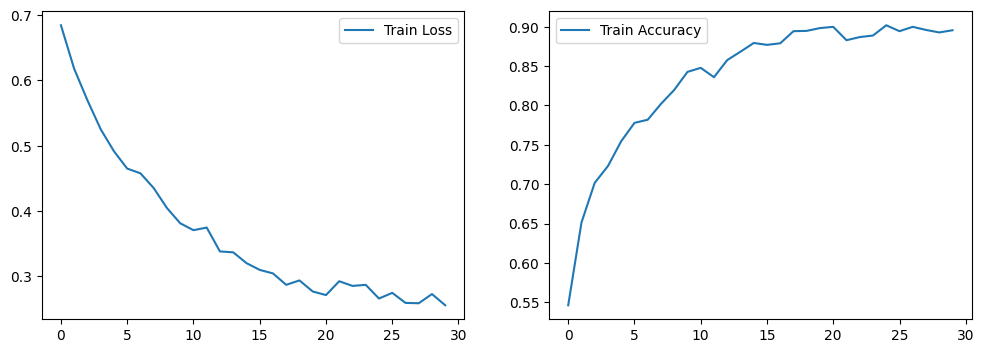

Epoch 1/30 - Loss: 0.7126, Accuracy: 0.5091
Epoch 2/30 - Loss: 0.6550, Accuracy: 0.6034
Epoch 3/30 - Loss: 0.5815, Accuracy: 0.7028
Epoch 4/30 - Loss: 0.5392, Accuracy: 0.7143
Epoch 5/30 - Loss: 0.5076, Accuracy: 0.7388
Epoch 6/30 - Loss: 0.4801, Accuracy: 0.7411
Epoch 7/30 - Loss: 0.4602, Accuracy: 0.7833
Epoch 8/30 - Loss: 0.4338, Accuracy: 0.8086
Epoch 9/30 - Loss: 0.4187, Accuracy: 0.8078
Epoch 10/30 - Loss: 0.4212, Accuracy: 0.8058
Epoch 11/30 - Loss: 0.3784, Accuracy: 0.8323
Epoch 12/30 - Loss: 0.3635, Accuracy: 0.8402
Epoch 13/30 - Loss: 0.3511, Accuracy: 0.8496
Epoch 14/30 - Loss: 0.3357, Accuracy: 0.8583
Epoch 15/30 - Loss: 0.3150, Accuracy: 0.8702
Epoch 16/30 - Loss: 0.2871, Accuracy: 0.8911
Epoch 17/30 - Loss: 0.2945, Accuracy: 0.8749
Epoch 18/30 - Loss: 0.3996, Accuracy: 0.8039
Epoch 19/30 - Loss: 0.3627, Accuracy: 0.8137
Epoch 20/30 - Loss: 0.2959, Accuracy: 0.8619
Epoch 21/30 - Loss: 0.2702, Accuracy: 0.8635
Epoch 22/30 - Loss: 0.2531, Accuracy: 0.8650
Epoch 23/30 - Loss:

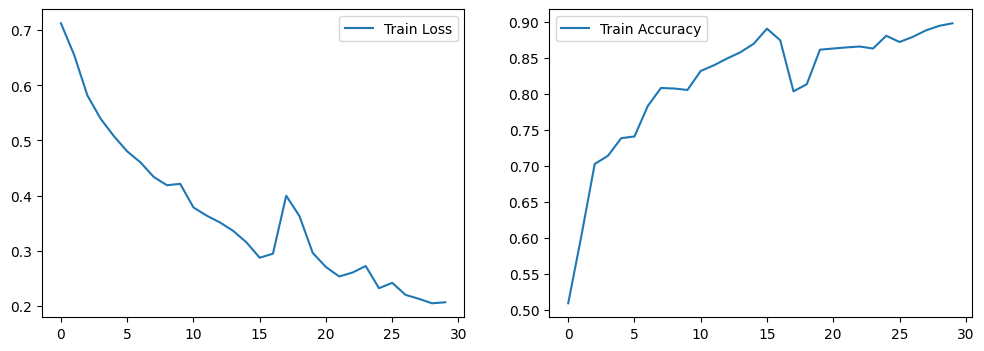

Epoch 1/30 - Loss: 0.6778, Accuracy: 0.5856
Epoch 2/30 - Loss: 0.5942, Accuracy: 0.6910
Epoch 3/30 - Loss: 0.5463, Accuracy: 0.7226
Epoch 4/30 - Loss: 0.5026, Accuracy: 0.7605
Epoch 5/30 - Loss: 0.4631, Accuracy: 0.8015
Epoch 6/30 - Loss: 0.4481, Accuracy: 0.8035
Epoch 7/30 - Loss: 0.4051, Accuracy: 0.8354
Epoch 8/30 - Loss: 0.3685, Accuracy: 0.8564
Epoch 9/30 - Loss: 0.3461, Accuracy: 0.8690
Epoch 10/30 - Loss: 0.3006, Accuracy: 0.8860
Epoch 11/30 - Loss: 0.3076, Accuracy: 0.8816
Epoch 12/30 - Loss: 0.2598, Accuracy: 0.8990
Epoch 13/30 - Loss: 0.2340, Accuracy: 0.9148
Epoch 14/30 - Loss: 0.2289, Accuracy: 0.9199
Epoch 15/30 - Loss: 0.2145, Accuracy: 0.9179
Epoch 16/30 - Loss: 0.1815, Accuracy: 0.9345
Epoch 17/30 - Loss: 0.1973, Accuracy: 0.9219
Epoch 18/30 - Loss: 0.1985, Accuracy: 0.9246
Epoch 19/30 - Loss: 0.1754, Accuracy: 0.9388
Epoch 20/30 - Loss: 0.2682, Accuracy: 0.8812
Epoch 21/30 - Loss: 0.1905, Accuracy: 0.9294
Epoch 22/30 - Loss: 0.1613, Accuracy: 0.9388
Epoch 23/30 - Loss:

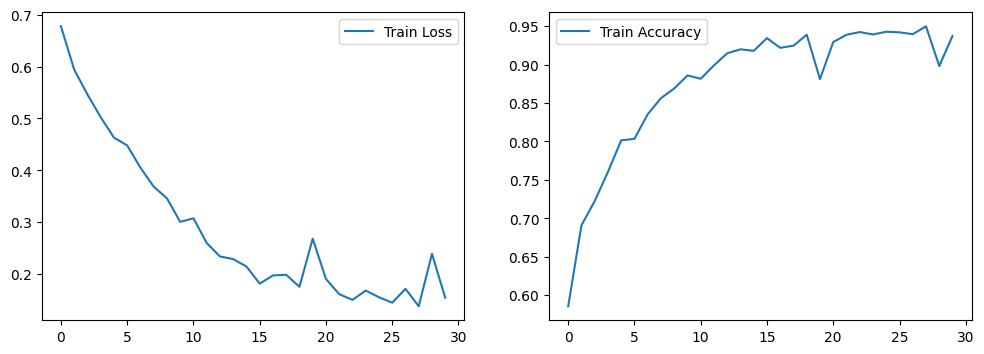

Epoch 1/30 - Loss: 0.7301, Accuracy: 0.5209
Epoch 2/30 - Loss: 0.6366, Accuracy: 0.6271
Epoch 3/30 - Loss: 0.5681, Accuracy: 0.7068
Epoch 4/30 - Loss: 0.5030, Accuracy: 0.7506
Epoch 5/30 - Loss: 0.4712, Accuracy: 0.7806
Epoch 6/30 - Loss: 0.4465, Accuracy: 0.7999
Epoch 7/30 - Loss: 0.4144, Accuracy: 0.8216
Epoch 8/30 - Loss: 0.4113, Accuracy: 0.8232
Epoch 9/30 - Loss: 0.3843, Accuracy: 0.8418
Epoch 10/30 - Loss: 0.3595, Accuracy: 0.8591
Epoch 11/30 - Loss: 0.3605, Accuracy: 0.8512
Epoch 12/30 - Loss: 0.3335, Accuracy: 0.8721
Epoch 13/30 - Loss: 0.3080, Accuracy: 0.8871
Epoch 14/30 - Loss: 0.3036, Accuracy: 0.8887
Epoch 15/30 - Loss: 0.2799, Accuracy: 0.8990
Epoch 16/30 - Loss: 0.2834, Accuracy: 0.8986
Epoch 17/30 - Loss: 0.3000, Accuracy: 0.8804
Epoch 18/30 - Loss: 0.2797, Accuracy: 0.8923
Epoch 19/30 - Loss: 0.3181, Accuracy: 0.8710
Epoch 20/30 - Loss: 0.2783, Accuracy: 0.8927
Epoch 21/30 - Loss: 0.2544, Accuracy: 0.9065
Epoch 22/30 - Loss: 0.2611, Accuracy: 0.8978
Epoch 23/30 - Loss:

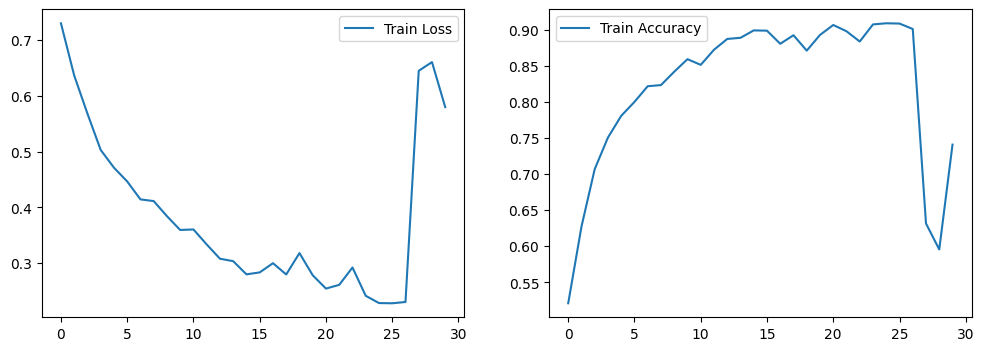

Epoch 1/30 - Loss: 0.7926, Accuracy: 0.5856
Epoch 2/30 - Loss: 0.6408, Accuracy: 0.6646
Epoch 3/30 - Loss: 0.7997, Accuracy: 0.6949
Epoch 4/30 - Loss: 0.5660, Accuracy: 0.7301
Epoch 5/30 - Loss: 0.5327, Accuracy: 0.7676
Epoch 6/30 - Loss: 0.5048, Accuracy: 0.7869
Epoch 7/30 - Loss: 0.4922, Accuracy: 0.7853
Epoch 8/30 - Loss: 0.4488, Accuracy: 0.8232
Epoch 9/30 - Loss: 0.4354, Accuracy: 0.8272
Epoch 10/30 - Loss: 0.4053, Accuracy: 0.8421
Epoch 11/30 - Loss: 0.3523, Accuracy: 0.8682
Epoch 12/30 - Loss: 0.3205, Accuracy: 0.8816
Epoch 13/30 - Loss: 0.3036, Accuracy: 0.8867
Epoch 14/30 - Loss: 0.2869, Accuracy: 0.8911
Epoch 15/30 - Loss: 0.2532, Accuracy: 0.9073
Epoch 16/30 - Loss: 0.3932, Accuracy: 0.8552
Epoch 17/30 - Loss: 0.2285, Accuracy: 0.9183
Epoch 18/30 - Loss: 0.2066, Accuracy: 0.9286
Epoch 19/30 - Loss: 0.1918, Accuracy: 0.9309
Epoch 20/30 - Loss: 0.1836, Accuracy: 0.9396
Epoch 21/30 - Loss: 0.2331, Accuracy: 0.9061
Epoch 22/30 - Loss: 0.2066, Accuracy: 0.9234
Epoch 23/30 - Loss:

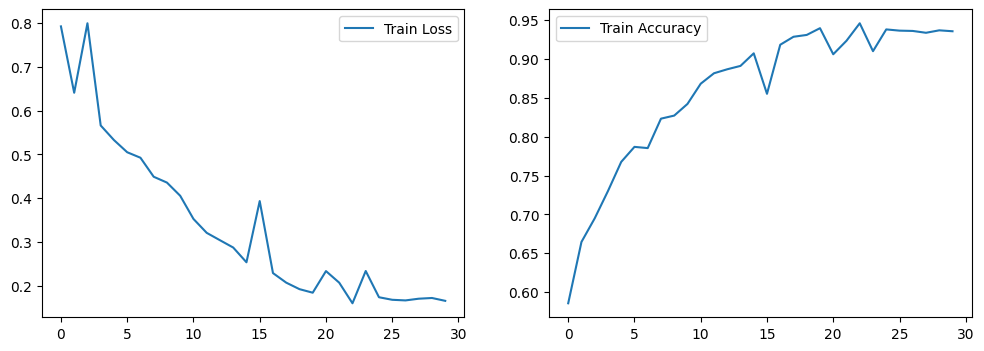

Epoch 1/30 - Loss: 0.6953, Accuracy: 0.5663
Epoch 2/30 - Loss: 0.6351, Accuracy: 0.6539
Epoch 3/30 - Loss: 0.6036, Accuracy: 0.6910
Epoch 4/30 - Loss: 0.5534, Accuracy: 0.7403
Epoch 5/30 - Loss: 0.5200, Accuracy: 0.7553
Epoch 6/30 - Loss: 0.4942, Accuracy: 0.7691
Epoch 7/30 - Loss: 0.4339, Accuracy: 0.8011
Epoch 8/30 - Loss: 0.4370, Accuracy: 0.8169
Epoch 9/30 - Loss: 0.4082, Accuracy: 0.8303
Epoch 10/30 - Loss: 0.3941, Accuracy: 0.8220
Epoch 11/30 - Loss: 0.3670, Accuracy: 0.8433
Epoch 12/30 - Loss: 0.3449, Accuracy: 0.8587
Epoch 13/30 - Loss: 0.3379, Accuracy: 0.8674
Epoch 14/30 - Loss: 0.3374, Accuracy: 0.8496
Epoch 15/30 - Loss: 0.3024, Accuracy: 0.8749
Epoch 16/30 - Loss: 0.2838, Accuracy: 0.8828
Epoch 17/30 - Loss: 0.2689, Accuracy: 0.8915
Epoch 18/30 - Loss: 0.2566, Accuracy: 0.8974
Epoch 19/30 - Loss: 0.2542, Accuracy: 0.8931
Epoch 20/30 - Loss: 0.2432, Accuracy: 0.8986
Epoch 21/30 - Loss: 0.2416, Accuracy: 0.8966
Epoch 22/30 - Loss: 0.2387, Accuracy: 0.9057
Epoch 23/30 - Loss:

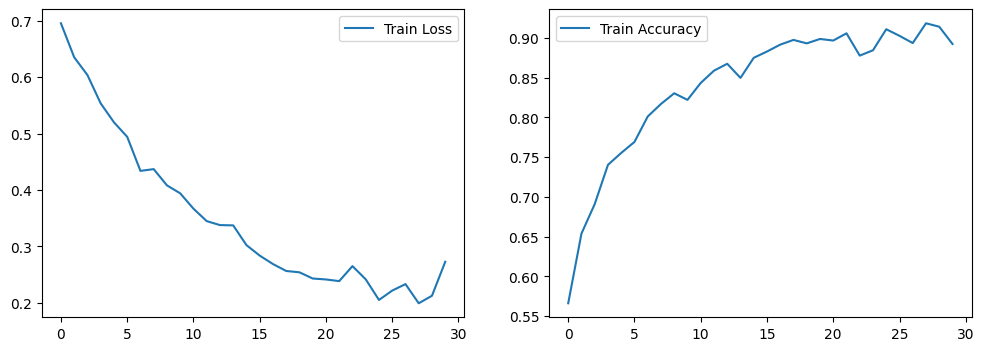


=== Final Results ===
BatchNorm + Noise 0.5: Mean Gini: 0.9807, Std: 0.0058
BatchNorm + Noise 1: Mean Gini: 0.9667, Std: 0.0104
BatchNorm + Noise 2: Mean Gini: 0.9478, Std: 0.0212
BatchNorm: Mean Gini: 0.9725, Std: 0.0273
No BatchNorm: Mean Gini: 0.9458, Std: 0.0389


In [6]:
# it takes long time to run 7 minutes

n_iterations = 10  # Number of iterations for each model
final_gini_results = []  # Stock the result

for config_name, use_bn, noise_scale in configs:
    print(f"\n=== {config_name} ===")
    gini_scores = []  # Stock the gini score for each model
    
    for iteration in range(n_iterations):
        #print(f"\nIteration {iteration + 1}/{n_iterations} for {config_name}")
        model = NeuralNetwork(input_size=X_train.shape[1], hidden_layer_1=16, hidden_layer_2=8, use_batch_norm=use_bn, noise_scale=noise_scale)
        model = train_model(model, train_loader, epochs=30, learning_rate=0.01)
        
        model.eval()
        y_true = []
        y_probs = []
        
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                y_true.extend(y_batch.numpy().flatten())
                y_probs.extend(outputs.numpy().flatten())
        
        gini_score, fpr, tpr = compute_gini(y_true, y_probs)
        gini_scores.append(gini_score)
        #print(f"Iteration {iteration + 1}: Gini Score ({config_name}): {gini_score:.4f}")
    
    mean_gini = np.mean(gini_scores)
    std_gini = np.std(gini_scores)
    final_gini_results.append((config_name, mean_gini, std_gini))
    #print(f"\nMean Gini Score for {config_name}: {mean_gini:.4f} ± {std_gini:.4f}")

print("\n=== Final Results ===")
for config_name, mean_gini, std_gini in final_gini_results:
    print(f"{config_name}: Mean Gini: {mean_gini:.4f}, Std: {std_gini:.4f}")